# Format SOCCOM BGC-Argo data into xarray dataset

## Import libraries

In [1]:
import os                                          # to open folders
import glob                                        # to open folders
import numpy               as np
import xarray              as xr
import pandas              as pd
from   tqdm.notebook       import tqdm_notebook    # for progress bar in loops

# for plotting:
from   datetime            import date             # for saving figures with today's date
import matplotlib
import matplotlib.pyplot   as plt
import cmocean.cm          as cmo

# for map
import cartopy                                     # to make map
import cartopy.crs         as ccrs                 # for map projection
import cartopy.feature     as cfeature             # to add land features to map
import matplotlib.path     as mpath                # to draw circle for map
import matplotlib.patches  as mpatches             # to draw boxes on map  

# Read in data

In [2]:
base_directory = '/Users/hannah/Documents/UW-PMEL/Research/SO_BGC_clusters_repo/data/'

directory_with_data             = os.path.join(base_directory, '01_raw/SOCCOM_BGC_Argo_float_data/SOCCOM_LoResQC_LIAR_19May2022_netcdf/')
directory_for_intermediate_data = os.path.join(base_directory, '02_intermediate/SOCCOM_BGC_Argo_float_data/SOCCOM_LoResQC_LIAR_19May2022_netcdf/')
directory_for_processed_data    = os.path.join(base_directory, '03_processed/SOCCOM_BGC_Argo_float_data/')
combined_nc_file_name           = 'SOCCOM_LoResQC_LIAR_19May2022_combined.nc'
combined_nc_file_name_SO_only   = 'SOCCOM_LoResQC_LIAR_19May2022_combined_SO_only.nc'

# path lists for files
list_of_paths = sorted(glob.glob(os.path.join(directory_with_data, '*.nc')))
len(list_of_paths)

349

# Functions

(don't change these)

In [3]:
# FUNCTIONS (don't change any of this)

# Define a function that smooths using a boxcar filter (running mean)
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


# Interpolate the data onto the standard depth grid given by x_int
def interpolate(x_int, xvals, yvals):
    yvals_int = []
    for n in range(0, len(yvals)):
        yvals_int.append(np.interp(x_int, xvals[n, :], yvals[n, :]))
    # convert the interpolated data from a list to numpy array
    return np.asarray(yvals_int)


# Calculate the vertically integrated data column inventory using the composite trapezoidal rule
def integrate(zi, data, depth_range):
    n_profs   = len(data)
    zi_start  = abs(zi - depth_range[0]).argmin()
    zi_end    = abs(zi - depth_range[1]).argmin()
    zi_struct = np.ones((n_profs, 1)) * zi[zi_start : zi_end]
    data      = data[:, zi_start : zi_end]
    col_inv   = []
    
    for n in range(0, len(data)):
        col_inv.append(np.trapz(data[n,:][~np.isnan(data[n,:])], zi_struct[n,:][~np.isnan(data[n,:])]))
    return col_inv


# Define a function that gets rid of repeated values 
def delete_rep(data):
        vals, inverse, count = np.unique(data, return_inverse=True,
                              return_counts=True)

        idx_vals_repeated = np.where(count > 1)[0]
        vals_repeated = vals[idx_vals_repeated]

        rows, cols = np.where(inverse == idx_vals_repeated[:, np.newaxis])
        _, inverse_rows = np.unique(rows, return_index=True)
        res = np.split(cols, inverse_rows[1:]) # res gives the indices of the repeated values
    
        for n in range(len(res)): 
            data[res[n-1]]=np.nan # set the repeated values to nans
        return data

In [4]:
# Function to read in QC flags and interpolate fields onto standard depth grid (don't change this unless you want to modify which variables get read in)
def interpolate_data(path, zi):
        dataset = xr.open_dataset(path)
        
        floatnum_string = os.path.basename(path).replace('.nc', '')
        juld = dataset.JULD.values
        lat  = dataset.Lat.values
        lon  = dataset.Lon.values
        
        n_profs   = dataset.N_PROF.size
        pres      = dataset.Pressure[:, ::-1] 
        temp      = dataset.Temperature[:, ::-1] 
        sal       = dataset.Salinity[:, ::-1] 
        oxy       = dataset.Oxygen[:, ::-1]  
        nitr      = dataset.Nitrate[:, ::-1]  
        chl       = dataset.Chl_a[:, ::-1] 
        sigthe    = dataset.Sigma_theta[:, ::-1]
        b_bp700   = dataset.b_bp700[:, ::-1]
        poc       = dataset.POC[:, ::-1]
        
        #set to NaN if QC flag is 4 or 8 (bad data)
        temp.values[dataset.Temperature_QFA[:, ::-1].values==2]=np.nan
        temp.values[dataset.Temperature_QFA[:, ::-1].values==3]=np.nan
        temp.values[dataset.Temperature_QFA[:, ::-1].values==4]=np.nan
        temp.values[dataset.Temperature_QFA[:, ::-1].values==8]=np.nan
        sal.values[ dataset.Salinity_QFA[:, ::-1].values==2]=np.nan
        sal.values[ dataset.Salinity_QFA[:, ::-1].values==3]=np.nan
        sal.values[ dataset.Salinity_QFA[:, ::-1].values==4]=np.nan
        sal.values[ dataset.Salinity_QFA[:, ::-1].values==8]=np.nan
        oxy.values[ dataset.Oxygen_QFA[:, ::-1].values==2]=np.nan
        oxy.values[ dataset.Oxygen_QFA[:, ::-1].values==3]=np.nan
        oxy.values[ dataset.Oxygen_QFA[:, ::-1].values==4]=np.nan
        oxy.values[ dataset.Oxygen_QFA[:, ::-1].values==8]=np.nan
        nitr.values[dataset.Nitrate_QFA[:, ::-1].values==2]=np.nan
        nitr.values[dataset.Nitrate_QFA[:, ::-1].values==3]=np.nan
        nitr.values[dataset.Nitrate_QFA[:, ::-1].values==4]=np.nan
        nitr.values[dataset.Nitrate_QFA[:, ::-1].values==8]=np.nan
        chl.values[ dataset.Chl_a_QFA[:, ::-1].values==2]=np.nan
        chl.values[ dataset.Chl_a_QFA[:, ::-1].values==3]=np.nan
        chl.values[ dataset.Chl_a_QFA[:, ::-1].values==4]=np.nan
        chl.values[ dataset.Chl_a_QFA[:, ::-1].values==8]=np.nan
        sigthe.values[ dataset.Sigma_theta_QFA[:, ::-1].values==2]=np.nan
        sigthe.values[ dataset.Sigma_theta_QFA[:, ::-1].values==3]=np.nan
        sigthe.values[ dataset.Sigma_theta_QFA[:, ::-1].values==4]=np.nan
        sigthe.values[ dataset.Sigma_theta_QFA[:, ::-1].values==8]=np.nan
        b_bp700.values[ dataset.b_bp700_QFA[:, ::-1].values==2]=np.nan
        b_bp700.values[ dataset.b_bp700_QFA[:, ::-1].values==3]=np.nan
        b_bp700.values[ dataset.b_bp700_QFA[:, ::-1].values==4]=np.nan
        b_bp700.values[ dataset.b_bp700_QFA[:, ::-1].values==8]=np.nan
        poc.values[ dataset.POC_QFA[:, ::-1].values==2]=np.nan
        poc.values[ dataset.POC_QFA[:, ::-1].values==3]=np.nan
        poc.values[ dataset.POC_QFA[:, ::-1].values==4]=np.nan
        poc.values[ dataset.POC_QFA[:, ::-1].values==8]=np.nan
        
        # interpolate onto uniform pressure grid from 0 to 1600 m with 5 m spacing 
        pres_int      = interpolate(zi, pres, pres)
        temp_int      = interpolate(zi, pres, temp)
        sal_int       = interpolate(zi, pres, sal)
        oxy_int       = interpolate(zi, pres, oxy)
        nitr_int      = interpolate(zi, pres, nitr)
        chl_int       = interpolate(zi, pres, chl)
        sigthe_int    = interpolate(zi, pres, sigthe)
        b_bp700_int   = interpolate(zi, pres, b_bp700)
        poc_int       = interpolate(zi, pres, poc)
        placeholder_int = interpolate(zi, pres, temp)
        placeholder_int[:, ::-1] = np.NaN
                 
        if 'pHinsitu' in list(dataset.keys()):
            pH        = dataset.pHinsitu[:, ::-1]
            pH.values[  dataset.pHinsitu_QFA[:, ::-1].values==2]=np.nan
            pH.values[  dataset.pHinsitu_QFA[:, ::-1].values==3]=np.nan
            pH.values[  dataset.pHinsitu_QFA[:, ::-1].values==4]=np.nan
            pH.values[  dataset.pHinsitu_QFA[:, ::-1].values==8]=np.nan
            pH_int    = interpolate(zi, pres, pH)
        else:
            pH_int = placeholder_int # this is to pick an array of the right shape/size
            # pH_int[:, ::-1] = np.NaN
            # pH_int.rename('pHinsitu')
        
        if 'pCO2_LIAR' in list(dataset.keys()):
            pco2      = dataset.pCO2_LIAR[:, ::-1] 
            pco2.values[dataset.pCO2_LIAR_QFA[:, ::-1].values==2]=np.nan
            pco2.values[dataset.pCO2_LIAR_QFA[:, ::-1].values==3]=np.nan
            pco2.values[dataset.pCO2_LIAR_QFA[:, ::-1].values==4]=np.nan
            pco2.values[dataset.pCO2_LIAR_QFA[:, ::-1].values==8]=np.nan
            pco2_int  = interpolate(zi, pres, pco2)
        else:
            pco2_int  = placeholder_int # this is to pick an array of the right shape/size
            # pco2_int.rename('pCO2_LIAR')
            
        if 'DIC_LIAR' in list(dataset.keys()):
            dic       = dataset.DIC_LIAR[:, ::-1]
            dic.values[ dataset.DIC_LIAR_QFA[:, ::-1].values==2]=np.nan
            dic.values[ dataset.DIC_LIAR_QFA[:, ::-1].values==3]=np.nan
            dic.values[ dataset.DIC_LIAR_QFA[:, ::-1].values==4]=np.nan
            dic.values[ dataset.DIC_LIAR_QFA[:, ::-1].values==8]=np.nan
            dic_int   = interpolate(zi, pres, dic)
        else:
            dic_int   = placeholder_int # this is to pick an array of the right shape/size
            # dic_int[:, ::-1] = np.NaN
            # dic_int.rename('DIC_LIAR')
        
        if 'TALK_LIAR' in list(dataset.keys()):
            talk      = dataset.TALK_LIAR[:, ::-1]  
            talk.values[dataset.TALK_LIAR_QFA[:, ::-1].values==2]=np.nan 
            talk.values[dataset.TALK_LIAR_QFA[:, ::-1].values==3]=np.nan
            talk.values[dataset.TALK_LIAR_QFA[:, ::-1].values==4]=np.nan
            talk.values[dataset.TALK_LIAR_QFA[:, ::-1].values==8]=np.nan
            talk_int  = interpolate(zi, pres, talk)
        else:
            talk_int  = placeholder_int # this is to pick an array of the right shape/size
            # talk_int[:, ::-1] = np.NaN
            # talk_int.rename('TALK_LIAR')
            
            
        if 'b_bp532' in list(dataset.keys()):
            b_bp532   = dataset.b_bp532[:, ::-1]
            b_bp532.values[ dataset.b_bp532_QFA[:, ::-1].values==2]=np.nan
            b_bp532.values[ dataset.b_bp532_QFA[:, ::-1].values==3]=np.nan
            b_bp532.values[ dataset.b_bp532_QFA[:, ::-1].values==4]=np.nan
            b_bp532.values[ dataset.b_bp532_QFA[:, ::-1].values==8]=np.nan
            b_bp532_int = interpolate(zi, pres, b_bp532)
        
        else:
            b_bp532_int = placeholder_int # this is to pick an array of the right shape/size
            # b_bp532_int[:, ::-1] = np.NaN
            # b_bp532_int.rename('b_bp532')

            
        if 'b_bp_corr' in list(dataset.keys()):
            b_bp_corr = dataset.b_bp_corr[:, ::-1]
            b_bp_corr.values[ dataset.b_bp_corr_QFA[:, ::-1].values==2]=np.nan
            b_bp_corr.values[ dataset.b_bp_corr_QFA[:, ::-1].values==3]=np.nan
            b_bp_corr.values[ dataset.b_bp_corr_QFA[:, ::-1].values==4]=np.nan
            b_bp_corr.values[ dataset.b_bp_corr_QFA[:, ::-1].values==8]=np.nan
            b_bp_corr_int = interpolate(zi, pres, b_bp_corr)
        else:
            b_bp_corr_int  = placeholder_int # this is to pick an array of the right shape/size
            # b_bp_corr_int[:, ::-1] = np.NaN
            # b_bp_corr_int.rename('b_bp_corr')            
            
        
        if 'CDOM' in list(dataset.keys()):
            cdom      = dataset.CDOM[:, ::-1]
            cdom.values[ dataset.CDOM_QFA[:, ::-1].values==2]=np.nan
            cdom.values[ dataset.CDOM_QFA[:, ::-1].values==3]=np.nan
            cdom.values[ dataset.CDOM_QFA[:, ::-1].values==4]=np.nan
            cdom.values[ dataset.CDOM_QFA[:, ::-1].values==8]=np.nan
            cdom_int  = interpolate(zi, pres, cdom)
        else:
            cdom_int  = placeholder_int # this is to pick an array of the right shape/size
            # cdom_int[:, ::-1] = np.NaN
            # cdom_int.rename('CDOM')
        
            
        
        return floatnum_string, juld, lat, lon, pres_int, temp_int, sal_int, pco2_int, dic_int, talk_int, pH_int, oxy_int, nitr_int, chl_int, sigthe_int, b_bp700_int, b_bp532_int, b_bp_corr_int, poc_int, cdom_int

In [5]:
# Function to combine interpolated data into xarray dataset and netcdf
def write_zint_nc(int_fd, directory_to_write, output_filename, 
                  variables_to_include = ['temp', 'sal', 'pco2', 'dic', 'talk', 'pH', 'oxy', 'nitr', 'chl']):   # int_fd is the output of the interpolate_data() function

    # Save as numpy arrays
    floatnum  = np.asarray(np.repeat(int_fd[0][:], len(int_fd[1][:])), dtype=object) # this could be done better
    juld      = np.asarray(int_fd[1][:]                              , dtype='datetime64[ns]')
    lat       = np.asarray(int_fd[2][:]                              , dtype=object)
    lon       = np.asarray(int_fd[3][:]                              , dtype=object)
    pres      = np.asarray(int_fd[4][:]                              , dtype=object)
    temp      = np.asarray(int_fd[5][:]                              , dtype=object)
    sal       = np.asarray(int_fd[6][:]                              , dtype=object)
    pco2      = np.asarray(int_fd[7][:]                              , dtype=object)
    dic       = np.asarray(int_fd[8][:]                              , dtype=object)
    talk      = np.asarray(int_fd[9][:]                              , dtype=object)
    pH        = np.asarray(int_fd[10][:]                             , dtype=object)
    oxy       = np.asarray(int_fd[11][:]                             , dtype=object)
    nitr      = np.asarray(int_fd[12][:]                             , dtype=object)
    chl       = np.asarray(int_fd[13][:]                             , dtype=object)
    sigthe    = np.asarray(int_fd[14][:]                             , dtype=object)
    b_bp700   = np.asarray(int_fd[15][:]                             , dtype=object)
    b_bp532   = np.asarray(int_fd[16][:]                             , dtype=object)
    b_bp_corr = np.asarray(int_fd[17][:]                             , dtype=object)
    poc       = np.asarray(int_fd[18][:]                             , dtype=object)
    cdom      = np.asarray(int_fd[19][:]                             , dtype=object)

    # Save as xarray dataarrays
    floatnum_da  = xr.DataArray(data = floatnum,  dims=['profile'])
    juld_da      = xr.DataArray(data = juld,      dims=['profile'])
    latitude_da  = xr.DataArray(data =  lat,      dims=['profile'])
    longitude_da = xr.DataArray(data =  lon,      dims=['profile'])
    temp_da      = xr.DataArray(data = temp,      dims=['profile','pressure'], coords=dict(pressure=zi))
    sal_da       = xr.DataArray(data =  sal,      dims=['profile','pressure'], coords=dict(pressure=zi))
    pco2_da      = xr.DataArray(data = pco2,      dims=['profile','pressure'], coords=dict(pressure=zi))
    dic_da       = xr.DataArray(data =  dic,      dims=['profile','pressure'], coords=dict(pressure=zi))
    talk_da      = xr.DataArray(data = talk,      dims=['profile','pressure'], coords=dict(pressure=zi))
    pH_da        = xr.DataArray(data =   pH,      dims=['profile','pressure'], coords=dict(pressure=zi))
    oxy_da       = xr.DataArray(data =  oxy,      dims=['profile','pressure'], coords=dict(pressure=zi))
    nitr_da      = xr.DataArray(data = nitr,      dims=['profile','pressure'], coords=dict(pressure=zi))
    chl_da       = xr.DataArray(data =  chl,      dims=['profile','pressure'], coords=dict(pressure=zi))
    sigthe_da    = xr.DataArray(data = sigthe,    dims=['profile','pressure'], coords=dict(pressure=zi))
    b_bp700_da   = xr.DataArray(data = b_bp700,   dims=['profile','pressure'], coords=dict(pressure=zi))
    b_bp532_da   = xr.DataArray(data = b_bp532,   dims=['profile','pressure'], coords=dict(pressure=zi))
    b_bp_corr_da = xr.DataArray(data = b_bp_corr, dims=['profile','pressure'], coords=dict(pressure=zi))
    poc_da       = xr.DataArray(data = poc,       dims=['profile','pressure'], coords=dict(pressure=zi))
    cdom_da      = xr.DataArray(data = cdom,      dims=['profile','pressure'], coords=dict(pressure=zi))


    # Combine arrays into xarray dataset
    dataset = temp_da.to_dataset(name  = 'temperature2')
    dataset = dataset.assign(floatnum  = floatnum_da)
    dataset = dataset.assign(latitude  = latitude_da)
    dataset = dataset.assign(longitude = longitude_da)
    dataset = dataset.assign(juld      = juld_da)

    # Add in year, month, and day
    dataset['year']  = dataset.juld.copy(data = pd.to_datetime(dataset.juld).year.astype(int))
    dataset['month'] = dataset.juld.copy(data = pd.to_datetime(dataset.juld).month.astype(int))
    dataset['day']   = dataset.juld.copy(data = pd.to_datetime(dataset.juld).day.astype(int))
    
    if 'temp'      in variables_to_include: dataset = dataset.assign(temperature = temp_da)
    if 'sal'       in variables_to_include: dataset = dataset.assign(salinity    = sal_da)
    if 'pco2'      in variables_to_include: dataset = dataset.assign(pco2        = pco2_da)
    if 'dic'       in variables_to_include: dataset = dataset.assign(dic         = dic_da)
    if 'talk'      in variables_to_include: dataset = dataset.assign(talk        = talk_da)
    if 'pH'        in variables_to_include: dataset = dataset.assign(pH          = pH_da)
    if 'oxy'       in variables_to_include: dataset = dataset.assign(oxygen      = oxy_da)
    if 'nitr'      in variables_to_include: dataset = dataset.assign(nitrate     = nitr_da)
    if 'chl'       in variables_to_include: dataset = dataset.assign(chl         = chl_da)
    if 'sigthe'    in variables_to_include: dataset = dataset.assign(sigma_theta = sigthe_da)
    if 'b_bp700'   in variables_to_include: dataset = dataset.assign(b_bp700     = b_bp700_da)
    if 'b_bp532'   in variables_to_include: dataset = dataset.assign(b_bp532     = b_bp532_da)
    if 'b_bp_corr' in variables_to_include: dataset = dataset.assign(b_bp_corr   = b_bp_corr_da)
    if 'poc'       in variables_to_include: dataset = dataset.assign(poc         = poc_da)
    if 'cdom'      in variables_to_include: dataset = dataset.assign(cdom        = cdom_da)
    
    # Drop extra temperature variable used to set up dataset:
    dataset = dataset.drop('temperature2')
    
    # Write dataset to .nc
    dataset.to_netcdf(path = os.path.join(directory_to_write, output_filename), mode='w')
    
    # # Function returns xarray dataset
    # return datasets


# Process data

In [6]:
# Initialize empty list of datasets
list_of_datasets = []

# Read in the data from all floats using a loop
for n in tqdm_notebook(range(len(list_of_paths)), desc = 'Progress through floats'):
    fn_zint = list_of_paths[n].replace('01_raw','02_intermediate').replace('.nc', '_zint.nc')
    
    # If depths haven't been interpolated yet:
    # if os.path.exists(fn_zint):
    #     print('* Check * --- if new variables were added, need to delete old _zint.nc file: ' + str(fn_zint))
    if not os.path.exists(fn_zint):
        path = list_of_paths[n]
        
        # Interpolate temperature onto uniform depth grid using the function from above
        zi = np.arange(0, 1605, 5)
        int_fd = interpolate_data(path, zi)
        write_zint_nc(int_fd, directory_to_write = directory_for_intermediate_data, output_filename = fn_zint, 
                      variables_to_include = ['temp', 'sal', 'pco2', 'dic', 'talk', 'pH', 'oxy', 'nitr', 'chl', 'sigthe', 'b_bp700', 'b_bp532', 'b_bp_corr', 'poc', 'cdom'])
    
    # Once depths have been interpolated:
    dataset_int = xr.open_dataset(fn_zint)
    
    # Append dataset to list of datasets     
    list_of_datasets.append(dataset_int)
    
# Concatanate all datasets together
datasets_all = xr.concat(list_of_datasets, dim = 'profile')

# Filter out anything north of 30 S:
dataset_SO = datasets_all.where(datasets_all.latitude <= -30, drop=True)

# Write dataset to .nc
datasets_all.to_netcdf(path = os.path.join(directory_for_processed_data, combined_nc_file_name),         mode='w')
dataset_SO.to_netcdf(  path = os.path.join(directory_for_processed_data, combined_nc_file_name_SO_only), mode='w')

# View datasets
dataset_SO

Progress through floats:   0%|          | 0/349 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:      (profile: 24521, pressure: 321)
Coordinates:
  * pressure     (pressure) int64 0 5 10 15 20 25 ... 1580 1585 1590 1595 1600
Dimensions without coordinates: profile
Data variables: (12/22)
    floatnum     (profile) object '5901492QC' '5901492QC' ... '5906508QC'
    latitude     (profile) float64 -50.2 -50.24 -50.29 ... -54.98 -56.24 -55.33
    longitude    (profile) float64 30.07 30.13 30.2 30.28 ... 130.6 132.4 131.7
    juld         (profile) datetime64[ns] 2008-02-20T09:06:59.999995136 ... 2...
    year         (profile) float64 2.008e+03 2.008e+03 ... 2.022e+03 2.022e+03
    month        (profile) float64 2.0 2.0 2.0 2.0 2.0 ... 3.0 4.0 4.0 5.0 5.0
    ...           ...
    sigma_theta  (profile, pressure) float64 26.77 26.77 26.77 ... 27.74 27.74
    b_bp700      (profile, pressure) float64 nan nan nan ... 0.0002233 0.0002223
    b_bp532      (profile, pressure) float64 nan nan nan nan ... nan nan nan nan
    b_bp_corr    (profile, pressure) float64 nan nan nan nan ... nan nan nan nan
    poc          (profile, pressure) float64 nan nan nan ... 0.8352 0.8335
    cdom         (profile, pressure) float64 nan nan nan ... 1.496 1.493 1.491

# Plots to look at the data

### Function to plot profile distributions

In [233]:
##########################################################################################
# Plot histogram of profile locations
##########################################################################################

def plot_histogram_of_profile_locations_circumpolar(ax, profiles, #lon_range, lat_range,
                                                    binsize              =   2,
                                                    myPlotLevels         =  30, 
                                                    lon_min              = -65,
                                                    lon_max              =  80,
                                                    lat_min              = -80,
                                                    lat_max              = -45,
                                                    vmin                 =   0, 
                                                    vmax                 = 200,
                                                    plot_edgecolor       = 'grey',
                                                    overplot_label_color = '#7B878F',
                                                    darker_label_color   = '#C9CCD4',
                                                    plot_facecolor       = '#E6F1F1',
                                                    plot_linewidth       =   1):
    
    
    from xhistogram.xarray import histogram
    
    # print
    # print("plot_tools.plot_histogram_of_profile_locations")
    
    
#     ###### SAVE NAME ######
#     savedate = date.today().strftime('%Y%m%d')
#     savepath = ploc
#     savename = 'map_histogram_circumpolar'

#     plt.rcParams["axes.edgecolor"] = plot_edgecolor
#     plt.rcParams["axes.linewidth"] = plot_linewidth
#     plt.figure(facecolor='none') 


    ###### SELECT DATA ######
    # ranges
    lon_range = (lon_min, lon_max)
    lat_range = (lat_min, lat_max)
    
    # bins
    lon_bins = np.arange(lon_range[0], lon_range[1]+binsize, binsize)
    lat_bins = np.arange(lat_range[0], lat_range[1]+binsize, binsize)

    # histogram
    hLatLon = histogram(profiles.longitude, profiles.latitude, bins=[lon_bins, lat_bins])

    
    
#     ###### SET UP PLOT ######
#     map_proj = ccrs.SouthPolarStereo()

#     # fig  = plt.figure(figsize=figsize, dpi=fig_dpi) # inches
#     ax  = plt.subplot(projection = map_proj)
    
    
    ###### SET UP MAP ######
    # Set up plot axes
    map_plot = map_southern_ocean_axes_setup(ax, fig, add_gridlines = False, color_land = True,
                                  land_facecolor        = overplot_label_color,
                                  land_edgecolor        = overplot_label_color,
                                  fontsize              = fontsize_medium,
                                  map_facecolor         = plot_facecolor, #'#d7dce8',
                                  coast_linewidth       = 1,
                                  gridlines_linewidth   = 4,
                                  girdlines_color       = 'grey',
                                  gridlines_alpha       = 0.1,
                                  longitude_label_color = darker_label_color,
                                  latitude_label_color  = overplot_label_color)

    # colormesh histogram
    CS = plt.pcolormesh(lon_bins, lat_bins, hLatLon.T, cmap=cmo.thermal, transform=ccrs.PlateCarree(), zorder=0)
    
    ### Add in coastlines/features
    coast_linewidth = 1
    land_facecolor  = overplot_label_color
    land_edgecolor  = overplot_label_color
    ax.add_feature(cfeature.LAND, zorder=1, linewidth=coast_linewidth, edgecolor=land_edgecolor, facecolor=land_facecolor)
    
    plt.clim(vmin, vmax)    
    
    
    ### Add in colorbar
    cbar = fig.colorbar(map_plot, ax=ax, orientation='horizontal')
    cbar.ax.set_ylabel('Number of profiles')

#     # separate colorbar
#     a = np.array([[vmin,vmax]])
#     plt.figure(figsize=(9, 1.5))
#     img = plt.imshow(a, cmap=discrete_cmap(10, cmo.thermal))
#     plt.gca().set_visible(False)
#     cax = plt.axes([0.1, 0.2, 0.8, 0.6])
#     cbar = plt.colorbar(orientation="horizontal", cax=cax)
    
#     # set colorbar tick color
#     cbar.ax.xaxis.set_tick_params(color=overplot_label_color)

#     # set colorbar edgecolor 
#     cbar.outline.set_edgecolor(overplot_label_color)

#     # set colorbar ticklabels
#     plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color=overplot_label_color)
#     cbar.ax.tick_params(labelsize=22)
    
    


### Function to visualize a variable

In [8]:
def plot_data_visualization(    
    dataset          : xr.core.dataset.Dataset,
    variable         : str,
) -> None:
    """
    Plot the data to see what is in the dataset
        Args:
        dataset  (xr.core.dataset.Dataset): The dataset to plot
        variable (str):                     The variable in the dataset to plot
    """
    
    from xhistogram.xarray import histogram
    
    # Check that variable is correct:
    if variable not in ['temperature', 'salinity', 'pco2', 'dic', 'talk', 'pH', 'oxygen', 'nitrate', 'chl', 'sigma_theta', 'b_bp700', 'b_bp532', 'poc', 'cdom']:
        raise ValueError('Variable ' + variable + ' not in accepted list of variables: temperature, salinity, pco2, dic, talk, pH, oxygen, nitrate, chl, sigma_theta, b_bp700, b_bp532, poc, cdom')

    
    ##############################
    ########## Set up ############
    ##############################

    ###### SAVE NAME ######
    savedate = date.today().strftime('%Y%m%d')
    savepath = '/Users/hannah/Documents/UW-PMEL/Research/SO_BGC_clusters_repo/results/figures/SOCCOM_BGC_Argo_floats/'
    savename = 'data_check_plots_for_' + str(variable)
    
    ###### SET PLOT VISUALS ######
    figsize               = [12, 12]      # x, y in inches
    linewidth             = 1             # width of line in lineplots
    fontsize_medium       = 12            # size of main font in figure
    fontsize_small        = 10            # size of detailed font in figure
    fontsize_tiny         = 8             # size of detailed font in figure
    plot_border_linewidth = 1
    overplot_label_color  = 'black'  # '#EFF3FC',
    tick_length = 5
    tick_width  = 1
    # plot_facecolor        = '#EFF3FC',

    ###### SET UP PLOT ######
    plt.rcParams["axes.edgecolor"] = overplot_label_color
    plt.rcParams["axes.linewidth"] = plot_border_linewidth
    plt.figure(facecolor='none') 
    
    fig  = plt.figure(figsize=figsize) # inches
    fig.tight_layout()
    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.8,
                        top=0.8,
                        wspace=0.5,
                        hspace=0.5)
    
    map_proj = ccrs.SouthPolarStereo()
    
    ax1 = plt.subplot(4, 2, 1)     # divide as 2x2, plot top left
    ax2 = plt.subplot(4, 2, 2)     # divide as 2x2, plot top right
    ax3 = plt.subplot(4, 2, 3)     # divide as 2x2, plot top left
    ax4 = plt.subplot(3, 2, 4, projection = map_proj)     # divide as 2x2, plot top right
    ax5 = plt.subplot(4, 2, 5)     # divide as 2x1, plot bottom
    ax6 = plt.subplot(4, 1, 4)     # divide as 2x1, plot bottom

    
    ################################################
    ########## FORMAT DATA FOR PLOTTING ############
    ################################################
    
    # Format data for plotting
    dataarray        = dataset[[variable]]    
    dataset_variable = dataset[['juld', 'year', 'month', 'latitude', 'longitude', 'profile', 'pressure', variable]]
    dataset_variable = dataset_variable.dropna(dim='profile', how='any')
    dataframe        = dataset.to_dataframe().reset_index().dropna(subset=[variable])
    dataframe = dataframe[dataframe.year >= 2007]

    
    
    
    ### SET VARIABLE PLOTTING PARAMETERS:
    
    if variable == 'temperature': 
        colormap = cmo.thermal
        xlabel = 'Temperature ($^\circ$C)'
        # dataframe = dataframe[dataframe.year >= 2008]
        
        hist_min_values = np.nanmin(dataframe.temperature)
        hist_max_values = 10
        
    if variable == 'salinity': 
        colormap = cmo.haline
        xlabel = 'Salinity (pss)'
        # dataframe = dataframe[dataframe.year >= 2008]
        
        hist_min_values = 33.2
        hist_max_values = 36.2
        
    if variable == 'pco2': 
        colormap = cmo.dense
        xlabel = '$p$CO$_2$ ($\mu$atm)'
        
        hist_min_values = 200
        hist_max_values = 700
        
    if variable == 'dic': 
        colormap = cmo.matter
        xlabel = 'DIC ($\mu$mol kg$^{-1}$)'
        
        hist_min_values = 2000
        hist_max_values = 2400
        
    if variable == 'talk': 
        colormap = cmo.turbid
        xlabel = 'Total Alkalinity ($\mu$mol kg$^{-1}$)'
        
        hist_min_values = 2250
        hist_max_values = 2420        
        
    if variable == 'pH': 
        colormap = cmo.tempo
        xlabel = 'pH'
        
        hist_min_values = np.nanmin(dataframe.pH)
        hist_max_values = np.nanmax(dataframe.pH)
        
    if variable == 'oxygen': 
        colormap = cmo.oxy
        xlabel = 'Oxygen ($\mu$mol kg$^{-1}$)'
        
        hist_min_values = np.nanmin(dataframe.oxygen)
        hist_max_values = np.nanmax(dataframe.oxygen)
        
    if variable == 'nitrate': 
        colormap = cmo.amp
        xlabel = 'Nitrate ($\mu$mol kg$^{-1}$)'  
        
        hist_min_values = np.nanmin(dataframe.nitrate)
        hist_max_values = np.nanmax(dataframe.nitrate)           
        
    if variable == 'sigma_theta': 
        colormap = cmo.dense
        xlabel = 'Potential denisty at sea surface (kg m$^{-3}$)'
        # dataframe = dataframe[dataframe.year >= 2008]
        
        hist_min_values = 24
        hist_max_values = 28.2
        
    if variable == 'b_bp700': 
        colormap = cmo.rain
        xlabel = 'Backscatter, 700 nm (m$^{-1}$)'
        # dataframe = dataframe[dataframe.year >= 2008]
        
        hist_min_values = 0
        hist_max_values = 0.002
        
    if variable == 'b_bp532': 
        colormap = cmo.rain
        xlabel = 'Backscatter, 532 nm (m$^{-1}$)'
        
        hist_min_values = np.nanmin(dataframe.b_bp532)
        hist_max_values = np.nanmax(dataframe.b_bp532)
        
    if variable == 'poc': 
        colormap = cmo.matter
        xlabel = 'POC (mmol m$^{-3}$)'
        
        hist_min_values = 0
        hist_max_values = 10

    if variable == 'cdom': 
        colormap = cmo.matter
        xlabel = 'CDOM ($^\circ$C)'
        
        hist_min_values = np.nanmin(dataframe.cdom)
        hist_max_values = np.nanmax(dataframe.cdom)
        
    if variable == 'chl': 
        colormap = cmo.algae
        xlabel = 'Chlorophyll (mg m$^{-3}$)'
        
        # dataframe = dataframe[dataframe.year >= 2008]
        dataframe = dataframe[dataframe.pressure <= 500]
        dataframe.loc[dataframe['chl'] > 10, 'chl'] = np.nan
        
        hist_min_values = 0.001
        hist_max_values = 0.1
        
        ax3.set_xscale('log')
        ax5.set_xscale('log')
        
    
    ################################################
    ########## PLOT! ###############################
    ################################################    
    
    # AXIS 1: Histogram by year  
    xr.plot.hist(dataset_variable.year, bins=np.arange(dataset_variable.year.min(), dataset_variable.year.max()+1), ax=ax1)
    ax1.set_xlabel('Year', color=overplot_label_color, fontsize=fontsize_medium)
    ax1.set_ylabel('Number of profiles', color=overplot_label_color, fontsize=fontsize_medium)  
    ax1.tick_params(axis = 'x', labelsize=fontsize_small, color=overplot_label_color, labelcolor=overplot_label_color, length=tick_length, width=tick_width)
    ax1.tick_params(axis = 'y', labelsize=fontsize_small, color=overplot_label_color, labelcolor=overplot_label_color, length=tick_length, width=tick_width)
    
    # AXIS 2: Histogram by month
    x_minor_tick_locations = [0, 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13]
    x_major_tick_locations =   [1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5 ]
    x_tick_labels          =   ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O',   'N',  'D']
    
    xr.plot.hist(dataset_variable.month, bins=12, ax=ax2, xticks=x_minor_tick_locations) # , cmap=cmo.thermal  should be able to add labels in xr.hist  , xticks=x_minor_tick_locations
    ax2.set_xlabel('Month', color=overplot_label_color, fontsize=fontsize_medium)
    ax2.set_ylabel('Number of profiles', color=overplot_label_color, fontsize=fontsize_medium)  
    # ax2.tick_params(axis = 'x', labelsize=fontsize_small, color=overplot_label_color, labelcolor=overplot_label_color, length=tick_length, width=tick_width)
    # ax2.tick_params(axis = 'y', labelsize=fontsize_small, color=overplot_label_color, labelcolor=overplot_label_color, length=tick_length, width=tick_width)
    # month_letters = ['J','F','M','A','M','J','J','A','S','O','N','D']
    # ax2.set_xticklabels(month_letters)
    
    # Set tick labels and locations
    # ax2.set_xlim(1, 13)
    # ax2.set_xticks(x_major_tick_locations)
    # ax2.set_xticks(x_minor_tick_locations, minor = True)
    # ax2.set_xticklabels(x_tick_labels)
    
#     ax2.tick_params(
#         axis='x',           # changes apply to the x-axis
#         which='major',      # only major ticks are affected
#         bottom=False,       # ticks along the bottom edge are off
#         top=False,          # ticks along the top edge are off
#         labelbottom=True)   # labels along the bottom edge are off

#     ax2.tick_params(
#         axis='x',           # changes apply to the x-axis
#         which='minor',      # only minor ticks are affected
#         bottom=True,        # ticks along the bottom edge are on
#         top=True,          # ticks along the top edge are off
#         labelbottom=False,  # labels along the bottom edge are off
#         labelsize=fontsize_medium, length=tick_length, width=tick_width)
    
    
    # AXIS 3 & 5: Histogram of data values
    if variable == 'chl':
        ax3.hist(dataframe[variable].values, bins=40, range=[0, 1])        
        section_plot = ax6.scatter(dataframe.juld, dataframe.pressure, c=dataframe[variable], cmap=colormap, s=1, norm=matplotlib.colors.LogNorm())
        
    else:
        ax3.hist(dataframe[variable].values, bins=40)
        section_plot = ax6.scatter(dataframe.juld, dataframe.pressure, c=dataframe[variable], cmap=colormap, s=1)
    
    ax5.hist(dataframe[variable].values, bins=40, range=[hist_min_values, hist_max_values])
        
    cbar_section = fig.colorbar(section_plot, ax=ax6, orientation='vertical')
    cbar_section.ax.set_ylabel(xlabel)
    
    # Set limits for plots
    xmin = np.nanmin(dataframe.juld)
    xmax = np.nanmax(dataframe.juld)
    ymin = np.nanmin(dataframe.pressure)
    ymax = np.nanmax(dataframe.pressure)
    
    ax6.set_ylabel('Pressure (dbar)')
    ax6.set_xlim([xmin, xmax])
    ax6.set_ylim([ymin, ymax])
    ax6.invert_yaxis() 

    # fig.suptitle('Section plot of ' + variable)
    # fig.autofmt_xdate()
        
        
    ax3.set_xlabel(xlabel, color=overplot_label_color, fontsize=fontsize_medium)
    ax3.set_ylabel('Number of profiles', color=overplot_label_color, fontsize=fontsize_medium)  
    ax3.tick_params(axis = 'x', labelsize=fontsize_small, color=overplot_label_color, labelcolor=overplot_label_color, length=tick_length, width=tick_width)
    ax3.tick_params(axis = 'y', labelsize=fontsize_small, color=overplot_label_color, labelcolor=overplot_label_color, length=tick_length, width=tick_width)
        
    ax5.set_xlabel(xlabel, color=overplot_label_color, fontsize=fontsize_medium)
    ax5.set_ylabel('Number of profiles', color=overplot_label_color, fontsize=fontsize_medium)  
    ax5.tick_params(axis = 'x', labelsize=fontsize_small, color=overplot_label_color, labelcolor=overplot_label_color, length=tick_length, width=tick_width)
    ax5.tick_params(axis = 'y', labelsize=fontsize_small, color=overplot_label_color, labelcolor=overplot_label_color, length=tick_length, width=tick_width)   
        
    # # AXIS 4: HISTOGRAM OF PROFILE DISTRIBUTION
    binsize              =   5
    myPlotLevels         =  30 
    lon_min              =   0
    lon_max              = 360
    lat_min              = -88
    lat_max              = -30
    vmin                 =   0 
    vmax                 = 200
    plot_edgecolor       =  'grey'
    overplot_label_color = '#7B878F'
    darker_label_color   = '#C9CCD4'
    plot_facecolor       = '#E6F1F1'
    plot_linewidth       =   1
    coast_linewidth      =   1
    
    ###### SELECT DATA ######
    # ranges
    lon_range = (lon_min, lon_max)
    lat_range = (lat_min, lat_max)
    
    # bins
    lon_bins = np.arange(lon_range[0], lon_range[1]+binsize, binsize)
    lat_bins = np.arange(lat_range[0], lat_range[1]+binsize, binsize)

    # histogram
    hLatLon = histogram(dataset_variable.longitude, dataset_variable.latitude, bins=[lon_bins, lat_bins])

    ###### SET UP MAP ######
    
    ### Limit the map to -40 degrees latitude and below.
    ax4.set_extent([-180, 180, -90, lat_max+0.6], ccrs.PlateCarree())  # set to -29.4 for map out to 30 degrees or -39.4 for map out to 40 degrees
   
    ### Tune the subplot layout
    # fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, wspace=0.02)
    
    ### Make the background of the plot white
    ax4.set_facecolor(plot_facecolor)

    ### Make SO plot boundary a circle
    def plot_circle_boundary(ax) -> None:
        """
        Make SO plot boundary a circle.
        Compute a circle in axes coordinates, which we can use as a boundary for the map.
        We can pan/zoom as much as we like - the boundary will be permanently circular.
        """
        theta  = np.linspace(0, 2 * np.pi, 100)
        center, radius = [0.5, 0.5], 0.5  ## could use 0.45 here, as Simon Thomas did
        verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform = ax.transAxes)

    plot_circle_boundary(ax4)

    # Colormesh histogram
    color_hist = ax4.pcolormesh(lon_bins, lat_bins, hLatLon.T, cmap=cmo.thermal, transform=ccrs.PlateCarree(), zorder=0)
    
    ### Add in coastlines/features
    land_facecolor  = overplot_label_color
    land_edgecolor  = overplot_label_color
    ax4.add_feature(cfeature.LAND, zorder=1, linewidth=coast_linewidth, edgecolor=land_edgecolor, facecolor=land_facecolor)
    # ax4.patch.set(ec=overplot_label_color)
    # ax4.set_clim(vmin, vmax)    
    
    ### Add in colorbar
    cbar_map = fig.colorbar(color_hist, ax=ax4, orientation='vertical')
    cbar_map.ax.set_ylabel('Number of profiles')

    ###### SAVE PLOT ######
    plt.savefig(savepath + savename + '_' + savedate + '.png', format='png', bbox_inches='tight')
    plt.show()

/var/folders/1g/9g0s0r6n4zg7zt3hqwll7gdr0000gn/T/ipykernel_44034/716192174.py:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(month_letters)


<Figure size 640x480 with 0 Axes>

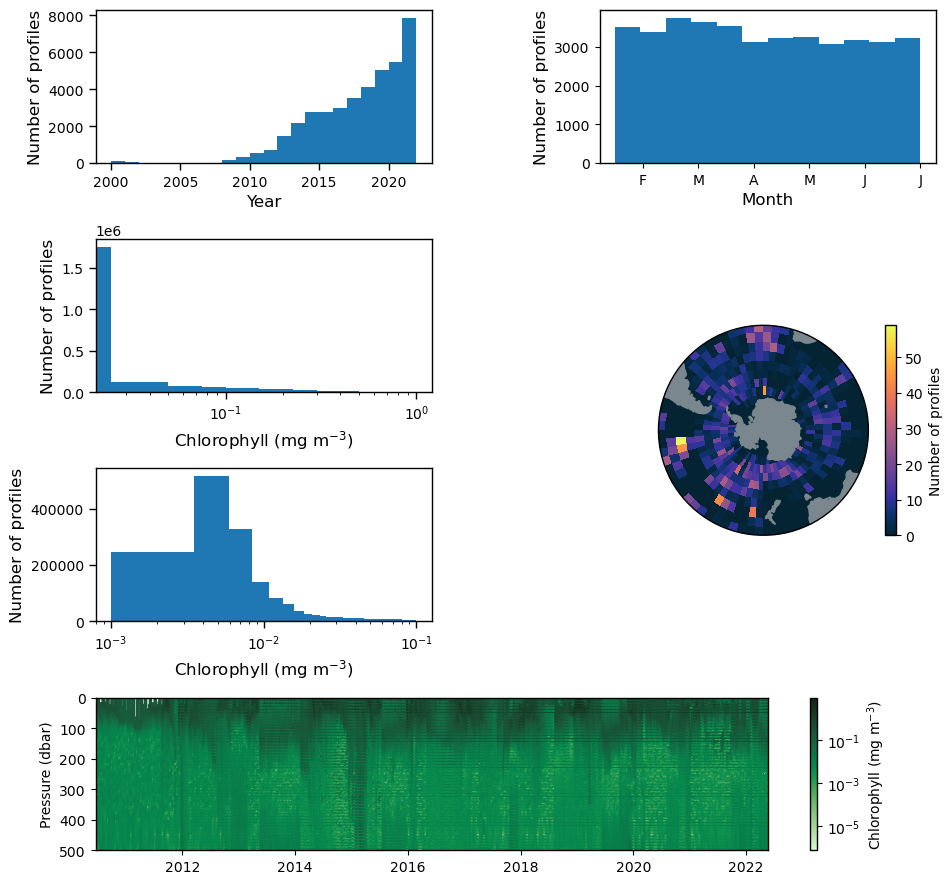

In [380]:
plot_data_visualization(test_dataset, 'chl')

<Figure size 640x480 with 0 Axes>

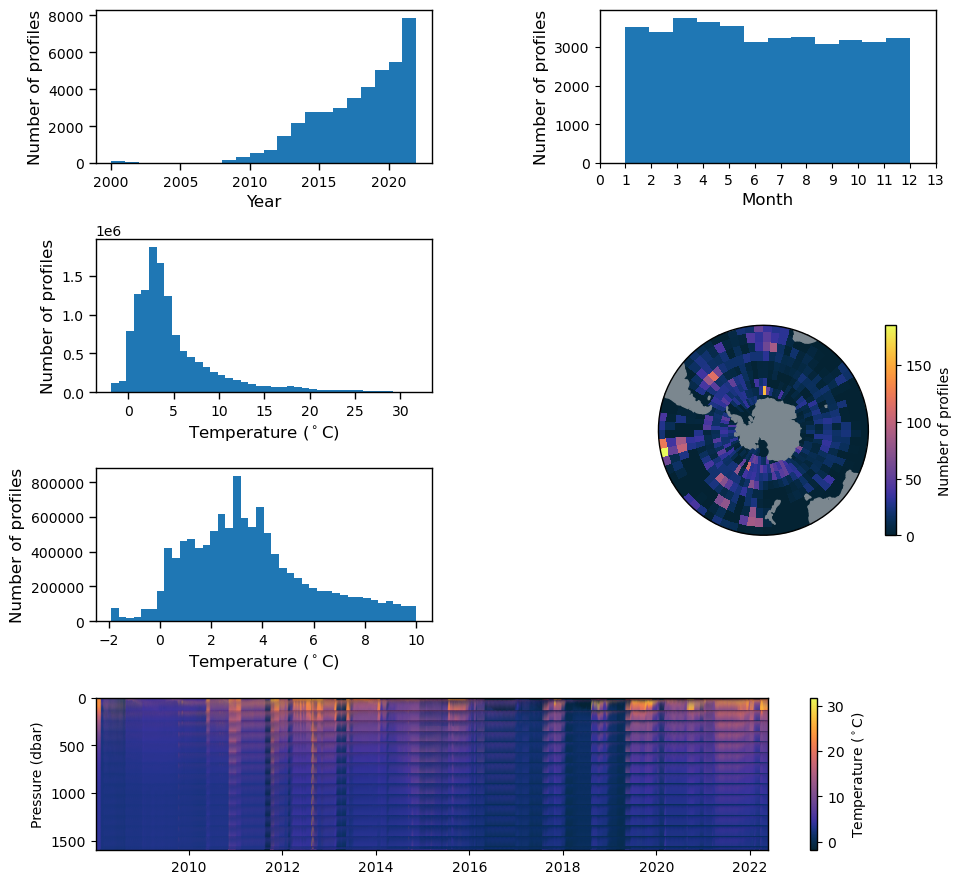

In [382]:
plot_data_visualization(datasets_all, 'temperature')

<Figure size 640x480 with 0 Axes>

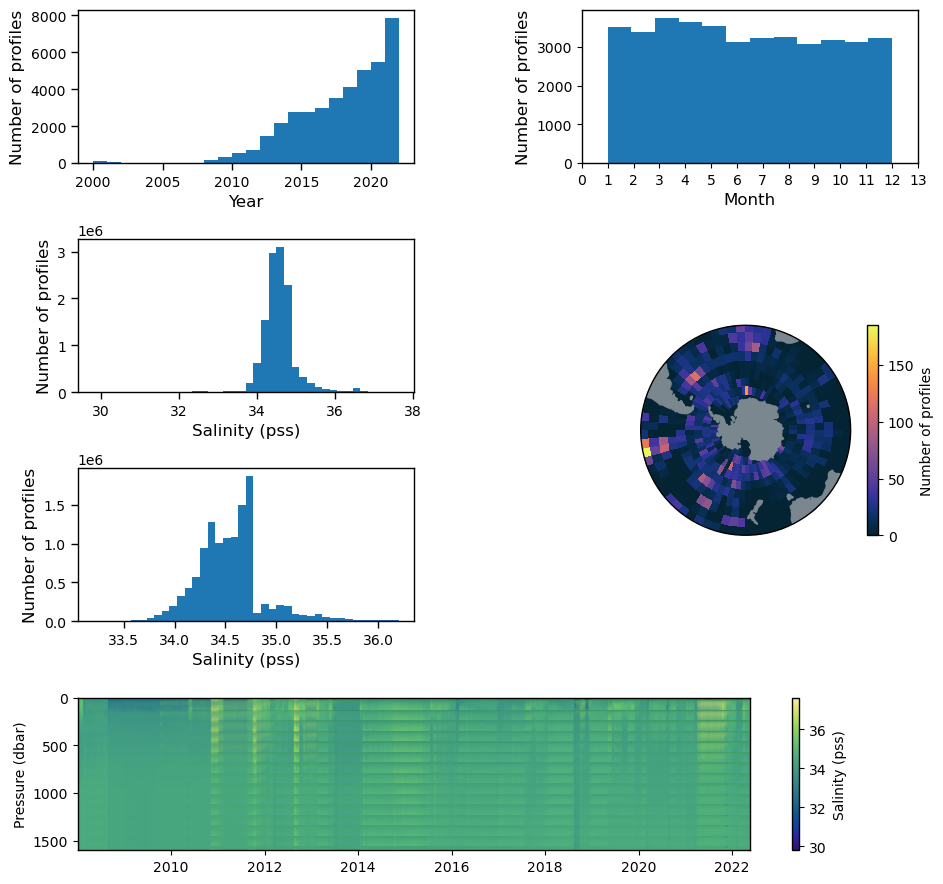

In [389]:
plot_data_visualization(datasets_all, 'salinity')

<Figure size 640x480 with 0 Axes>

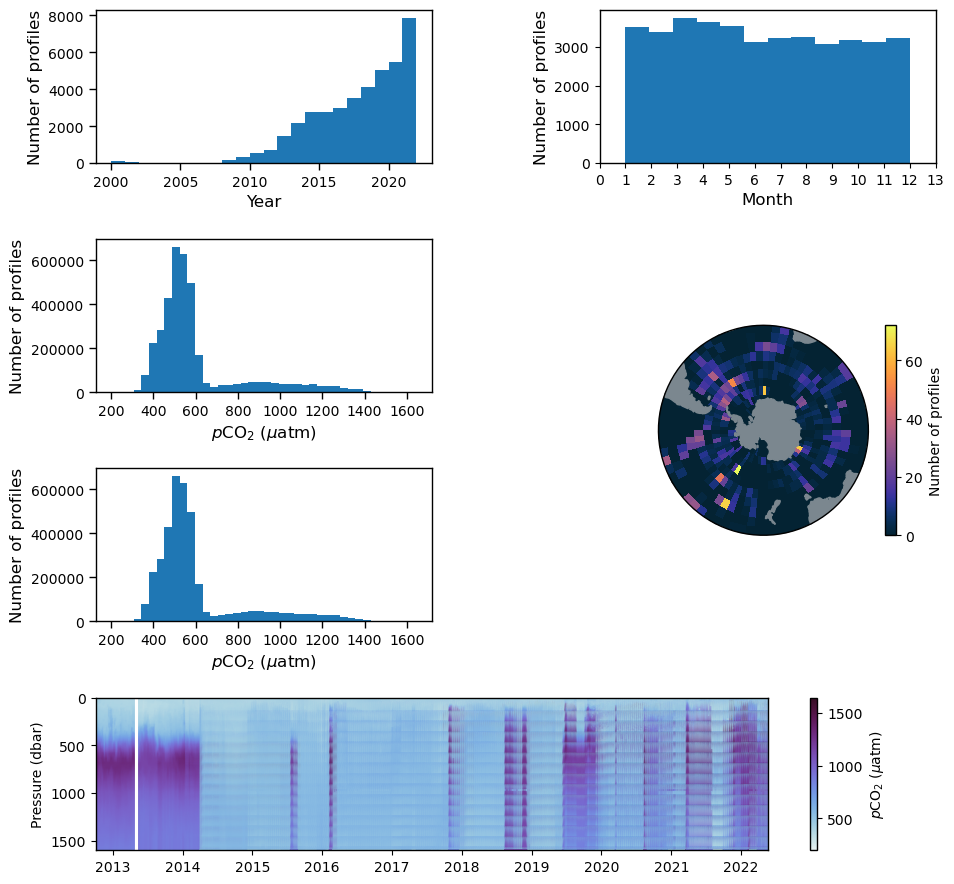

In [390]:
plot_data_visualization(datasets_all, 'pco2')

<Figure size 640x480 with 0 Axes>

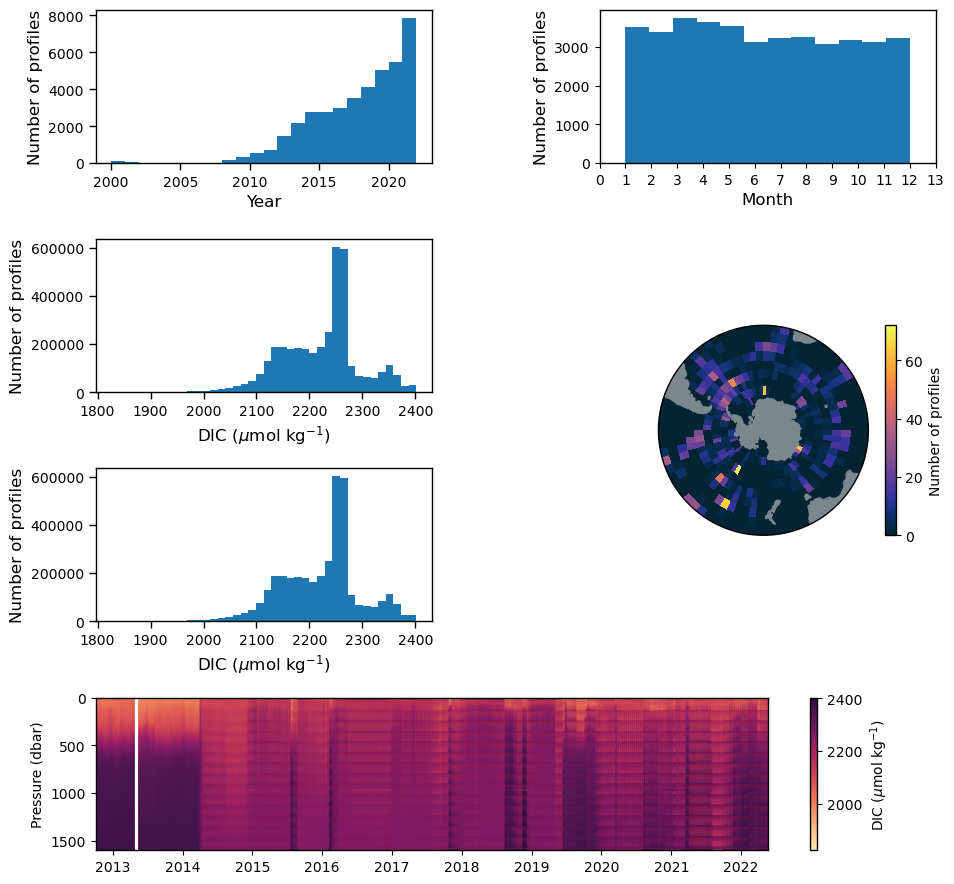

In [391]:
plot_data_visualization(datasets_all, 'dic')

<Figure size 640x480 with 0 Axes>

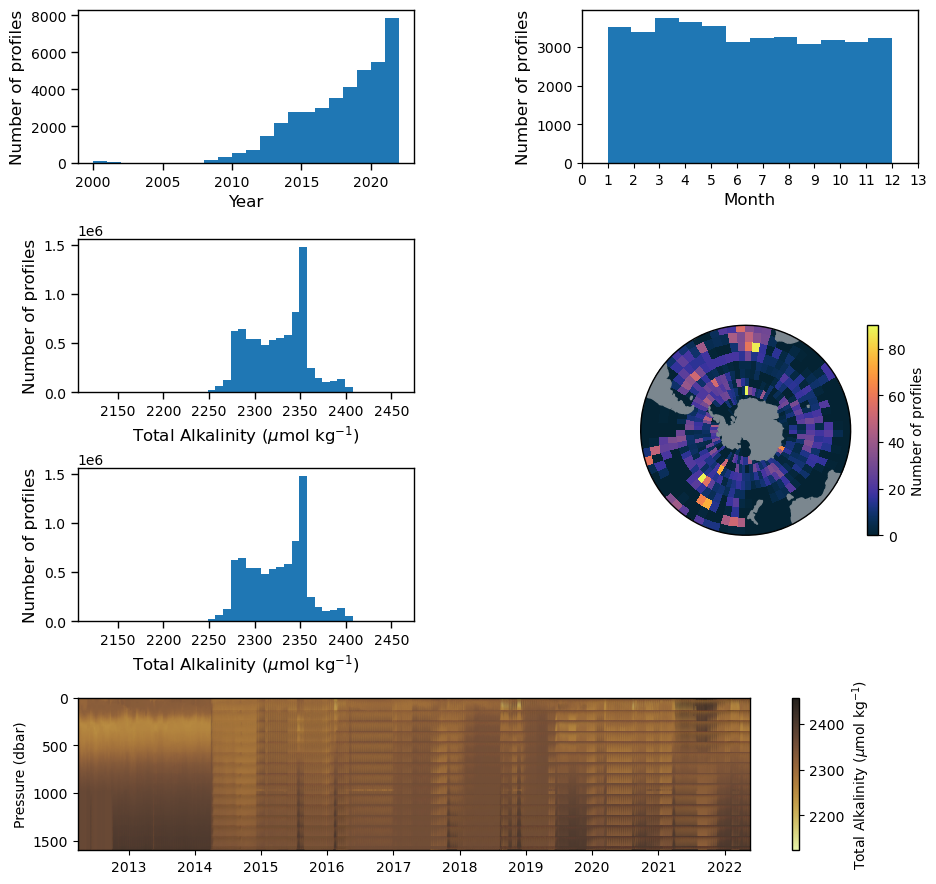

In [393]:
plot_data_visualization(datasets_all, 'talk')

<Figure size 640x480 with 0 Axes>

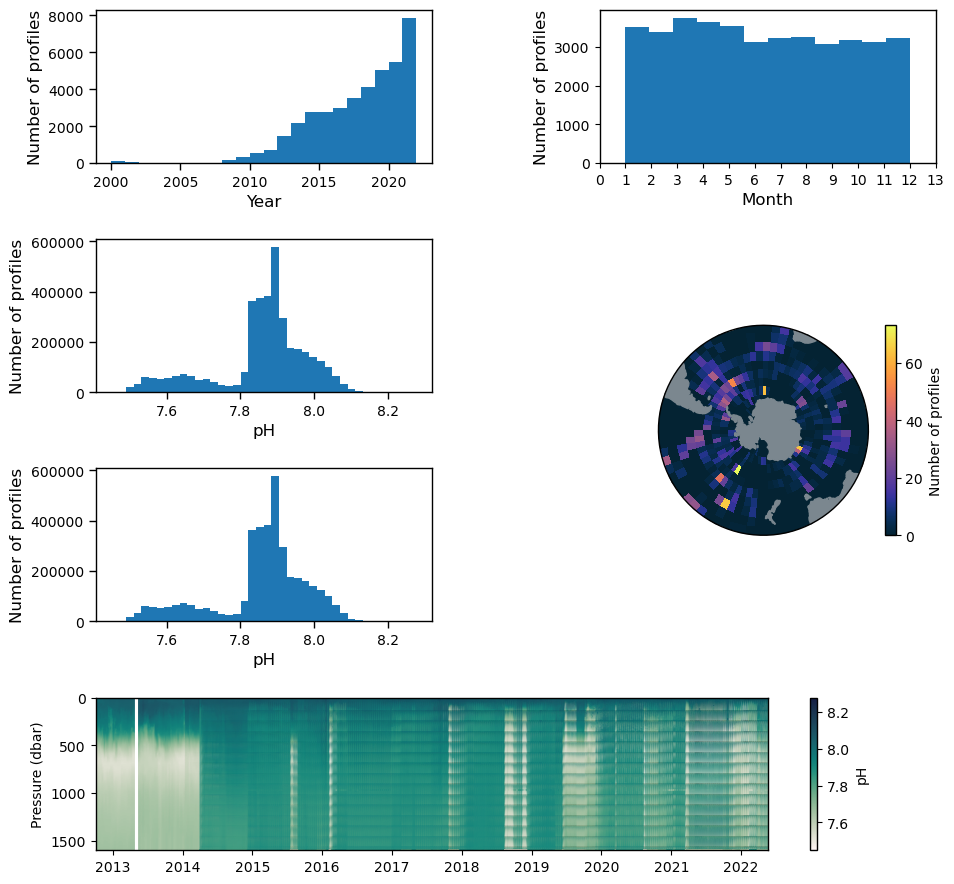

In [394]:
plot_data_visualization(datasets_all, 'pH')

<Figure size 640x480 with 0 Axes>

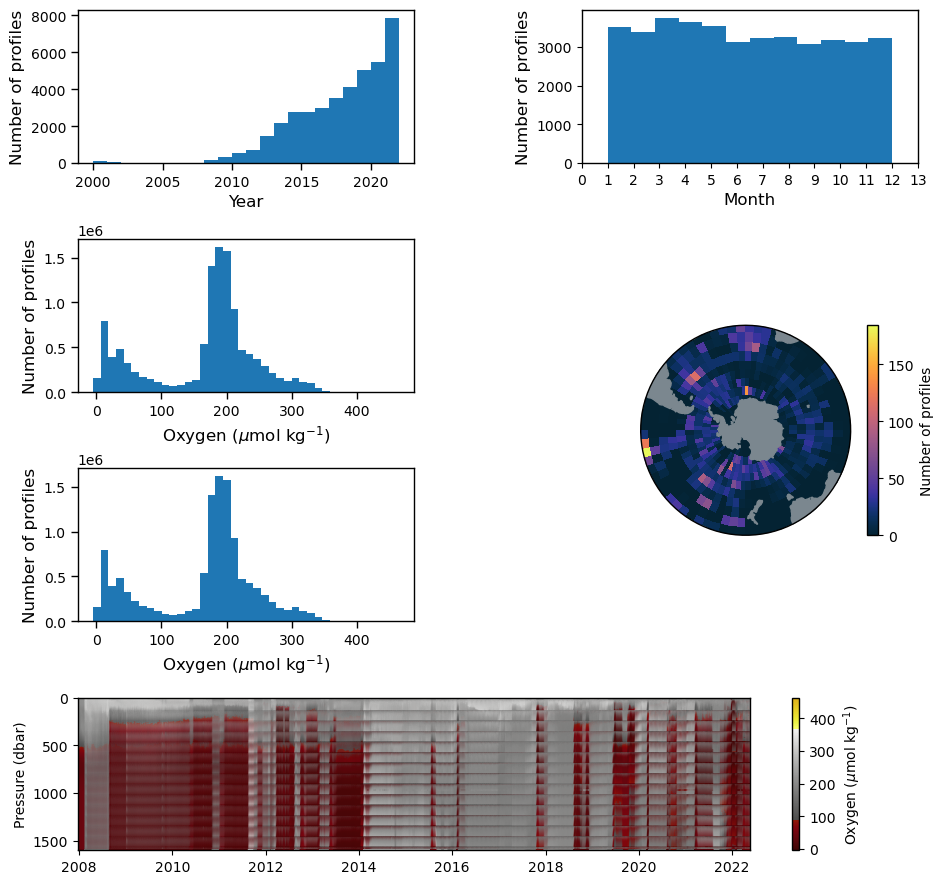

In [395]:
plot_data_visualization(datasets_all, 'oxygen')

<Figure size 640x480 with 0 Axes>

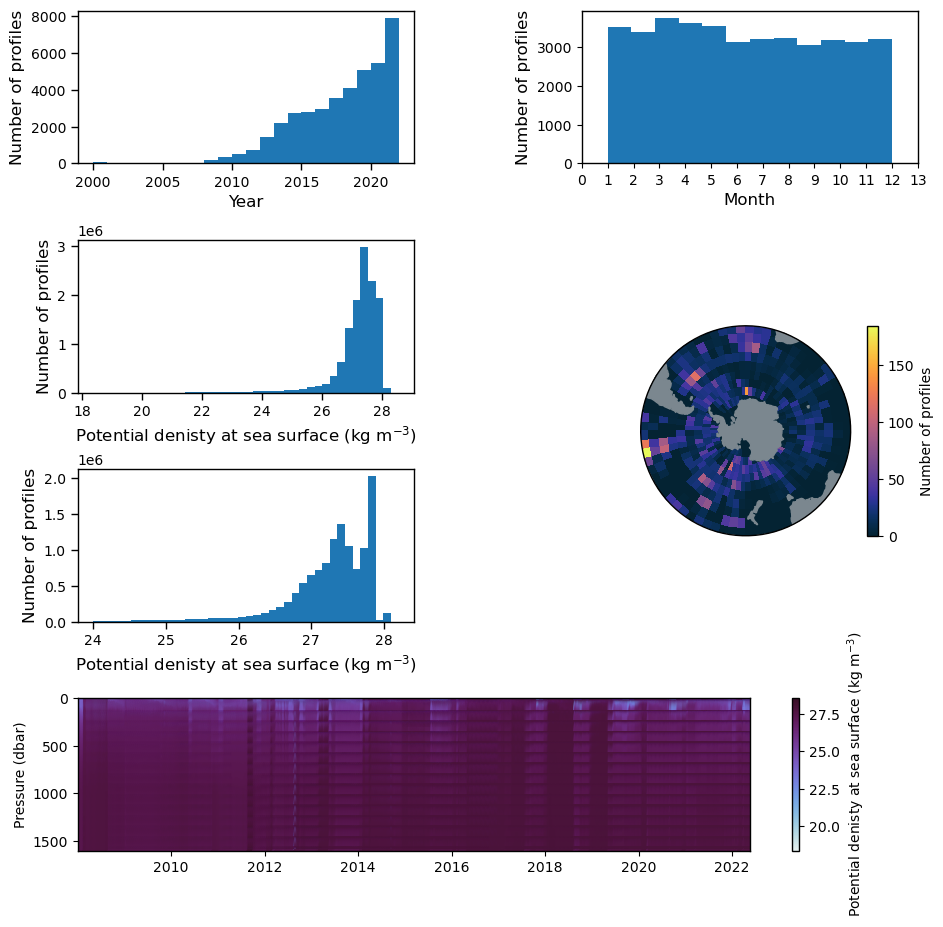

In [399]:
plot_data_visualization(datasets_all, 'sigma_theta')

<Figure size 640x480 with 0 Axes>

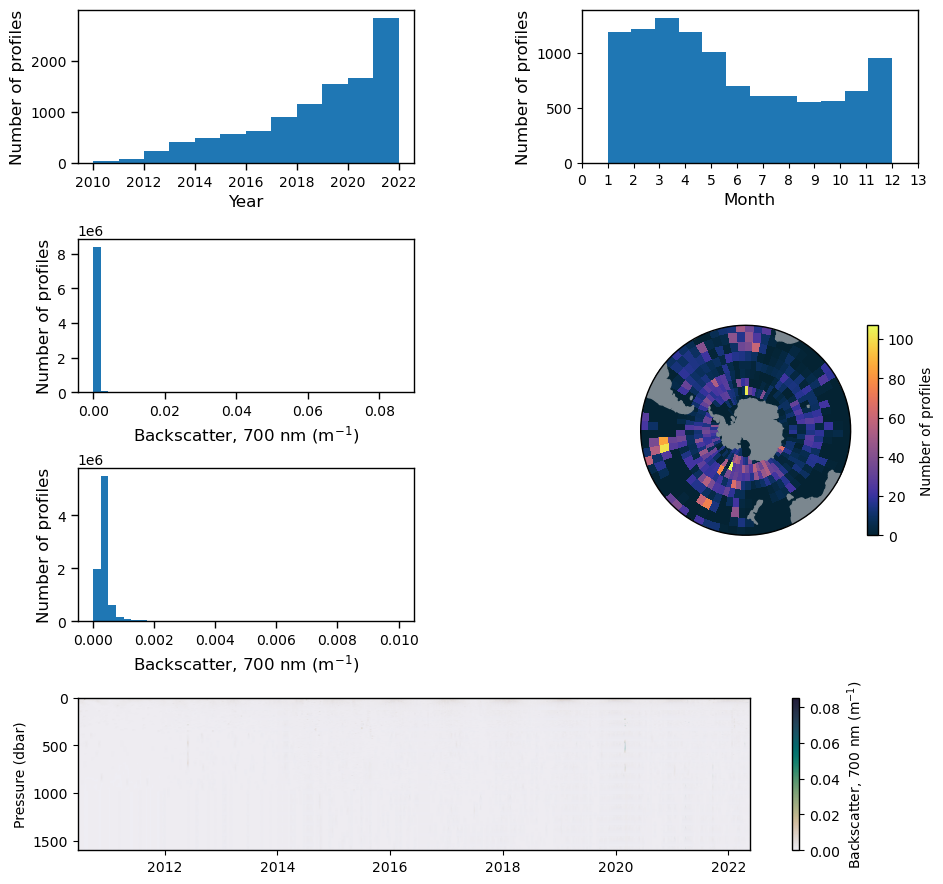

In [409]:
plot_data_visualization(datasets_all, 'b_bp700')

<Figure size 640x480 with 0 Axes>

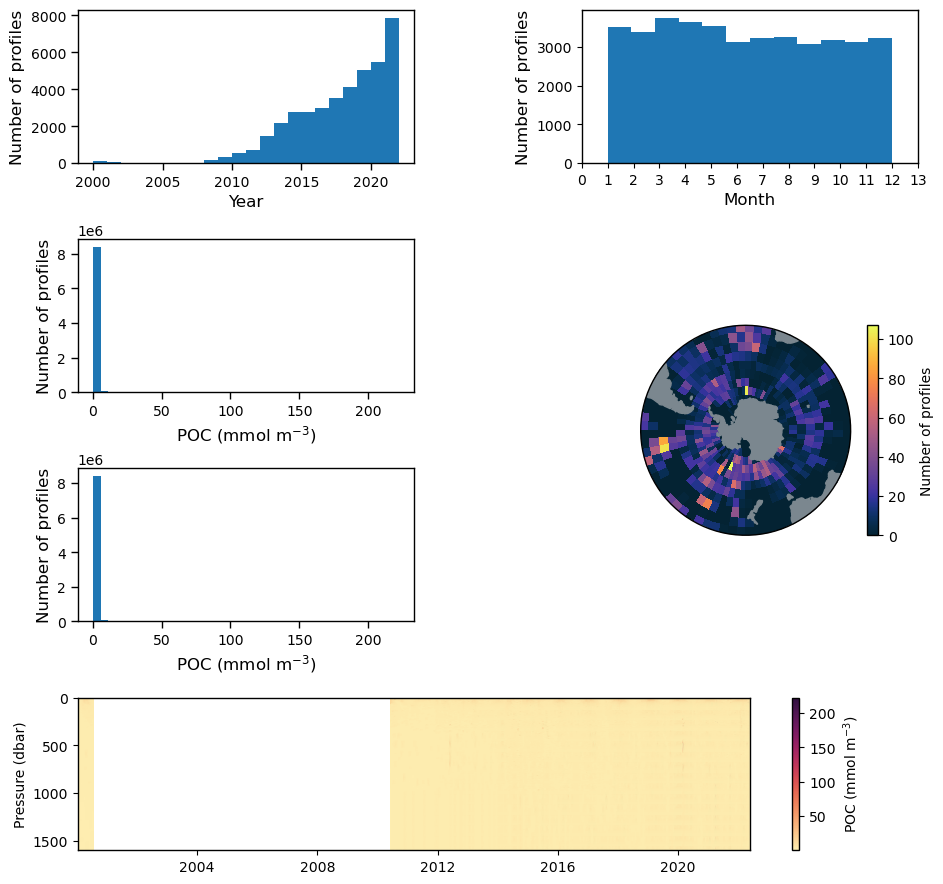

In [403]:
plot_data_visualization(datasets_all, 'poc')

In [ ]:
plot_data_visualization(datasets_all, 'cdom')

temperature


<Figure size 640x480 with 0 Axes>

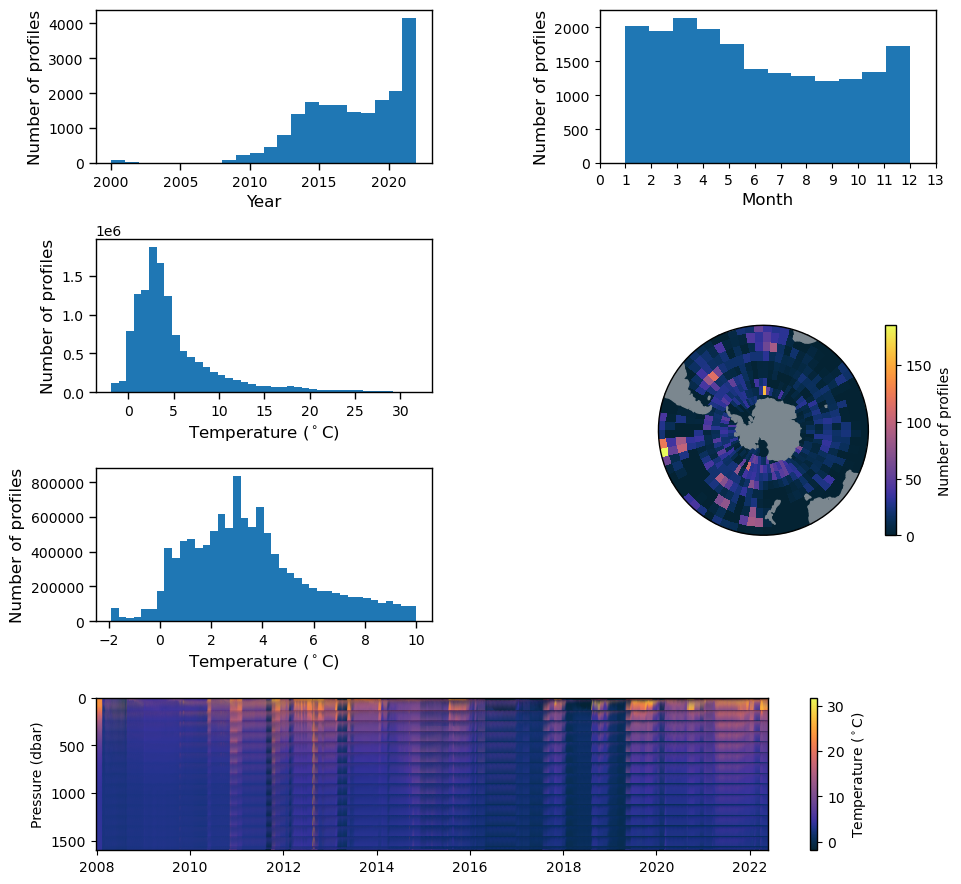

salinity


<Figure size 640x480 with 0 Axes>

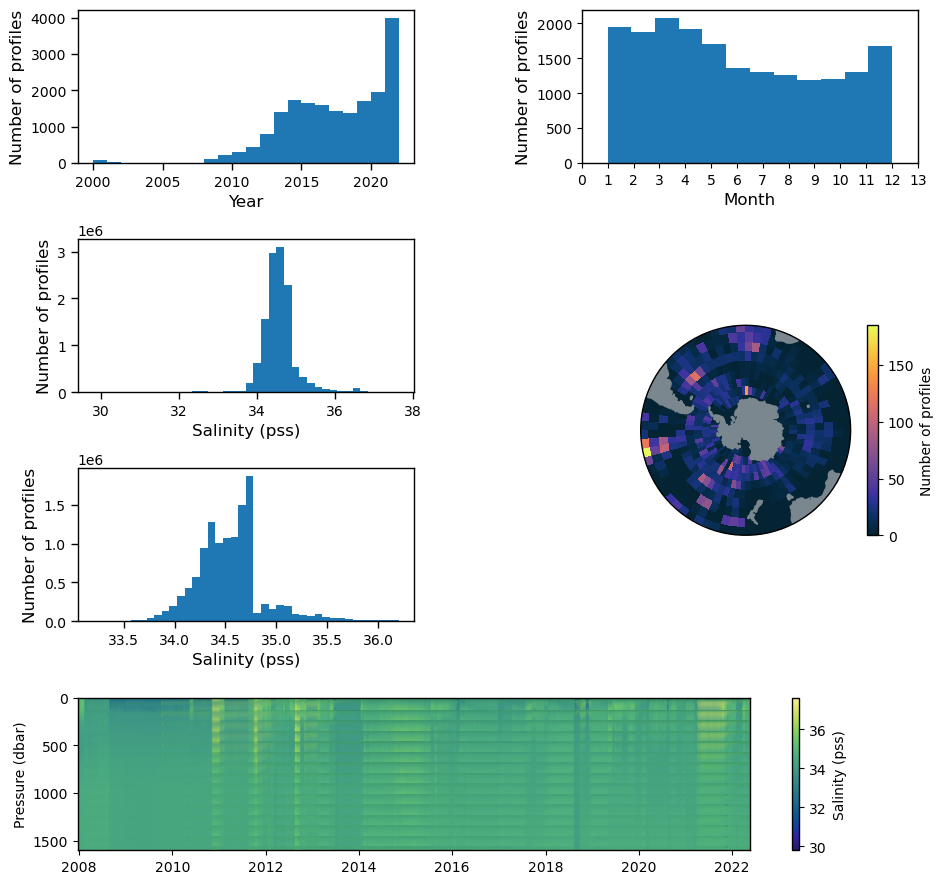

pco2


<Figure size 640x480 with 0 Axes>

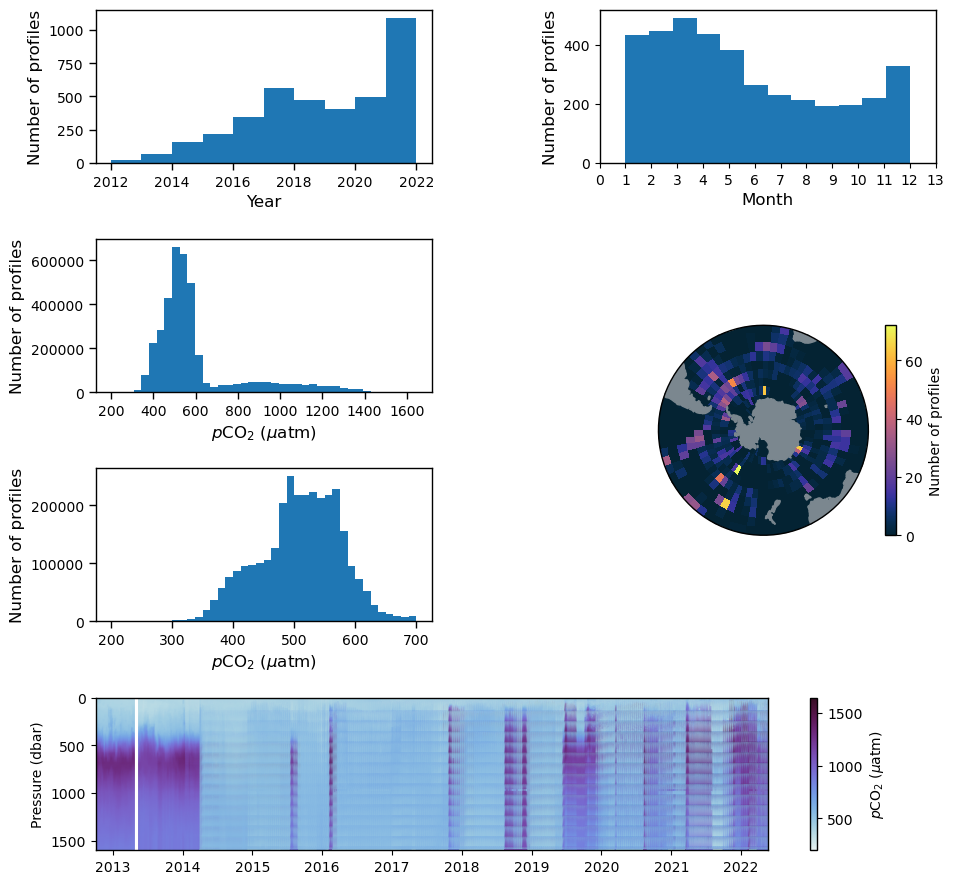

dic


<Figure size 640x480 with 0 Axes>

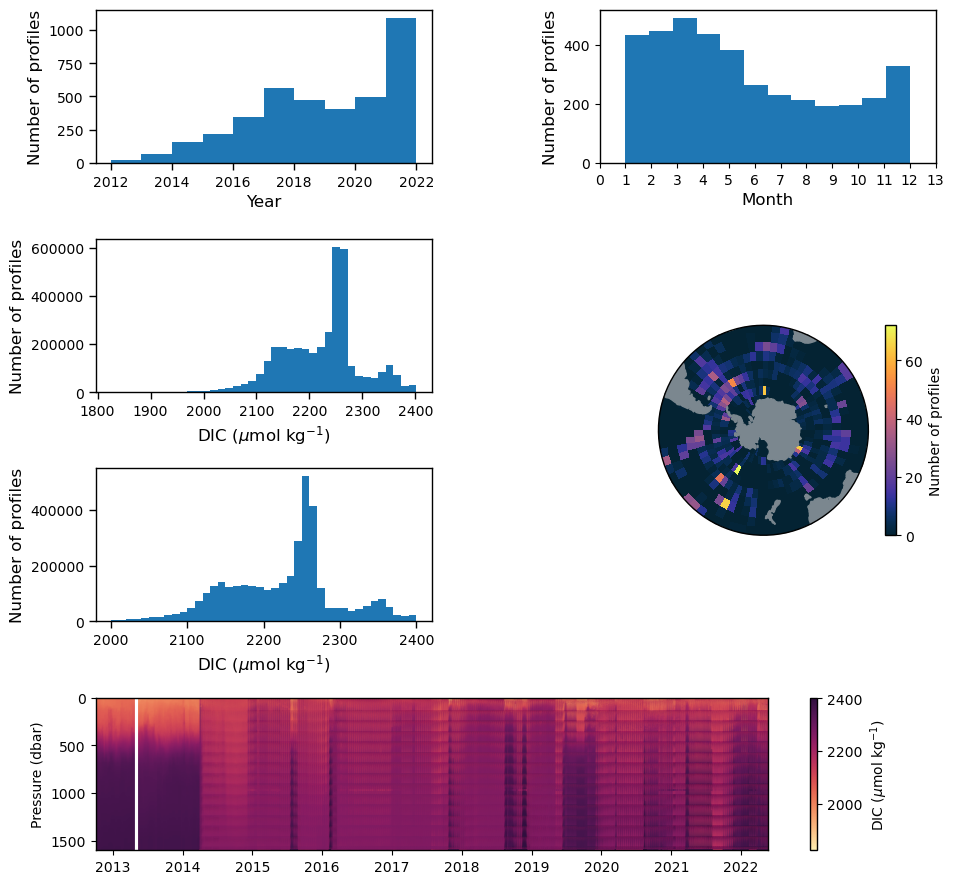

talk


<Figure size 640x480 with 0 Axes>

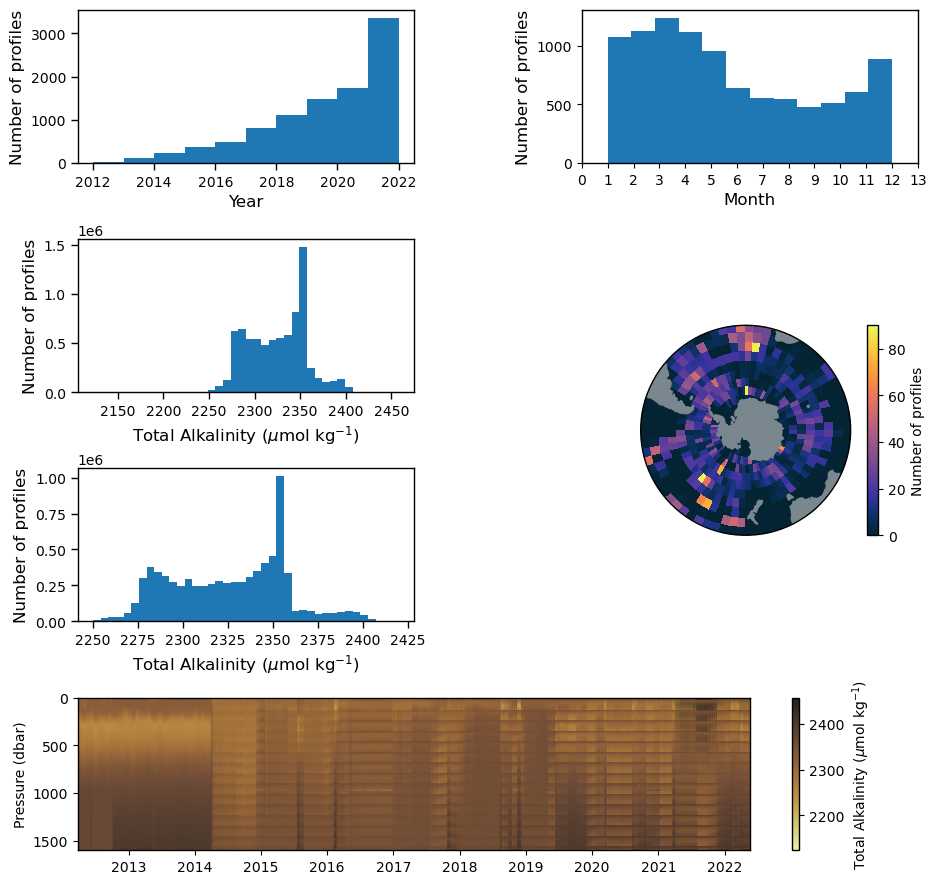

pH


<Figure size 640x480 with 0 Axes>

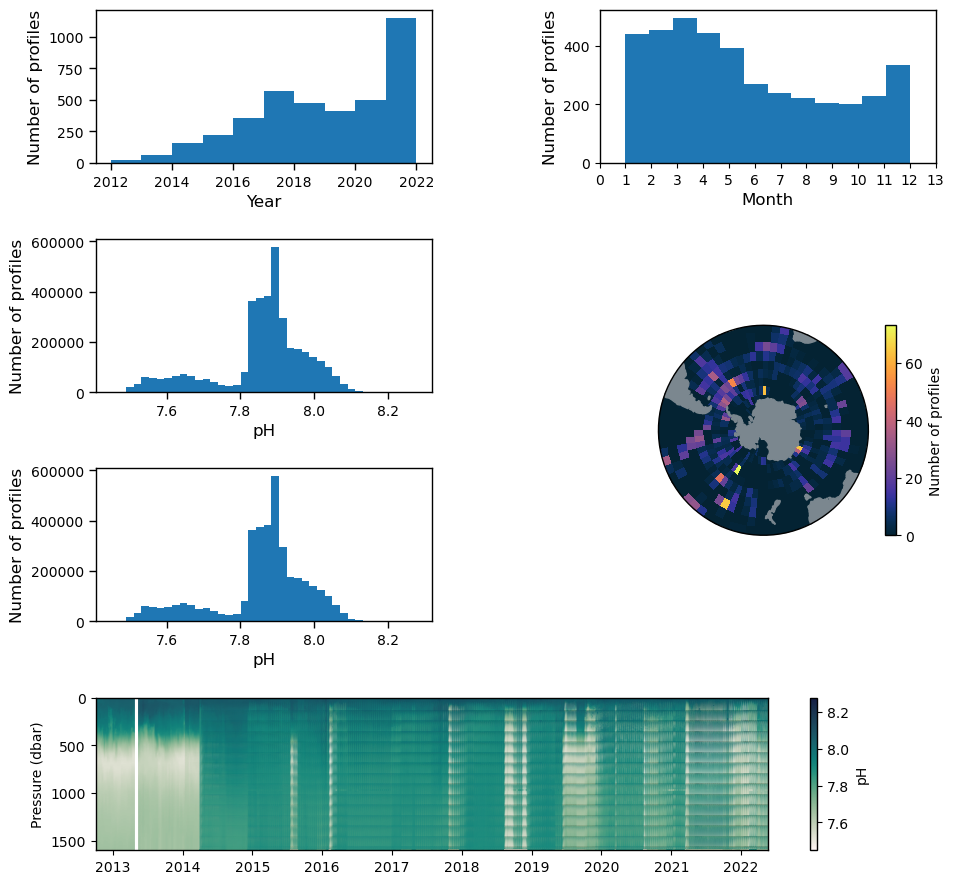

oxygen


<Figure size 640x480 with 0 Axes>

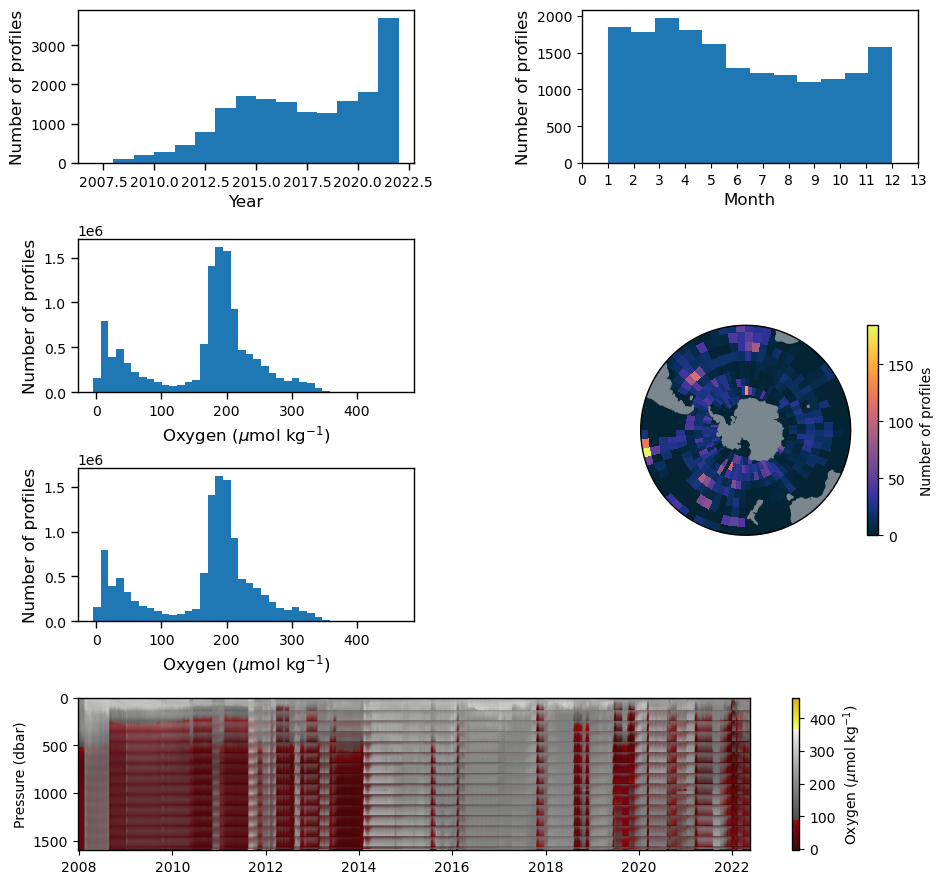

nitrate


<Figure size 640x480 with 0 Axes>

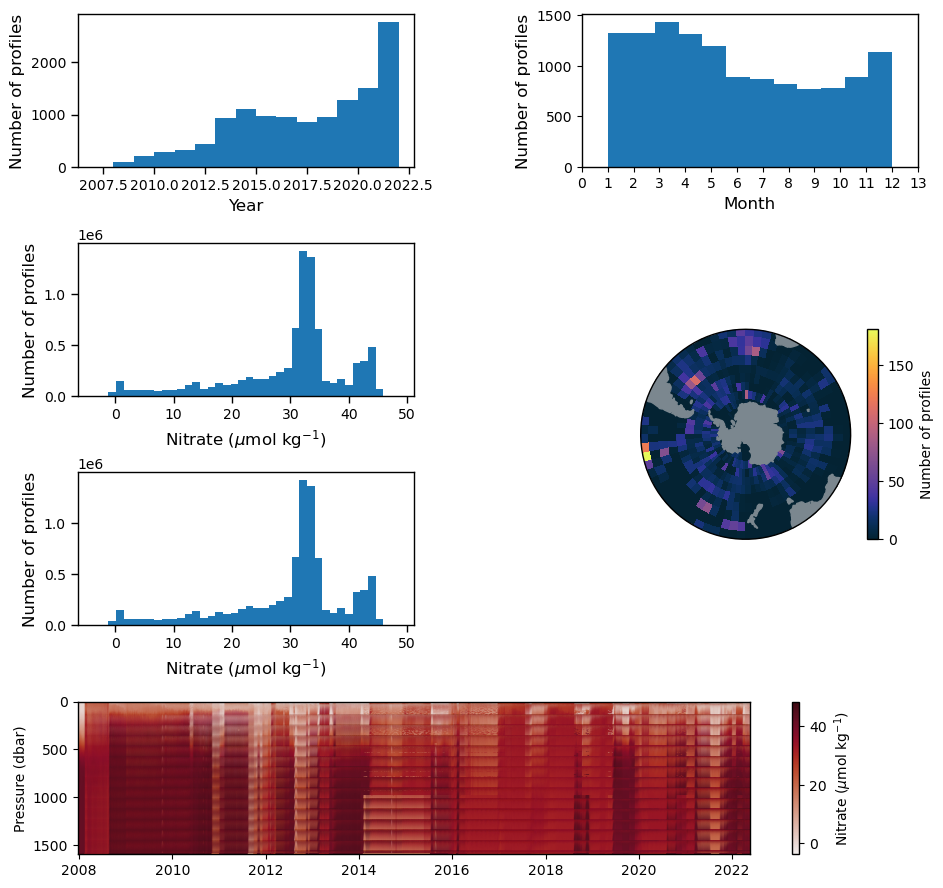

chl


<Figure size 640x480 with 0 Axes>

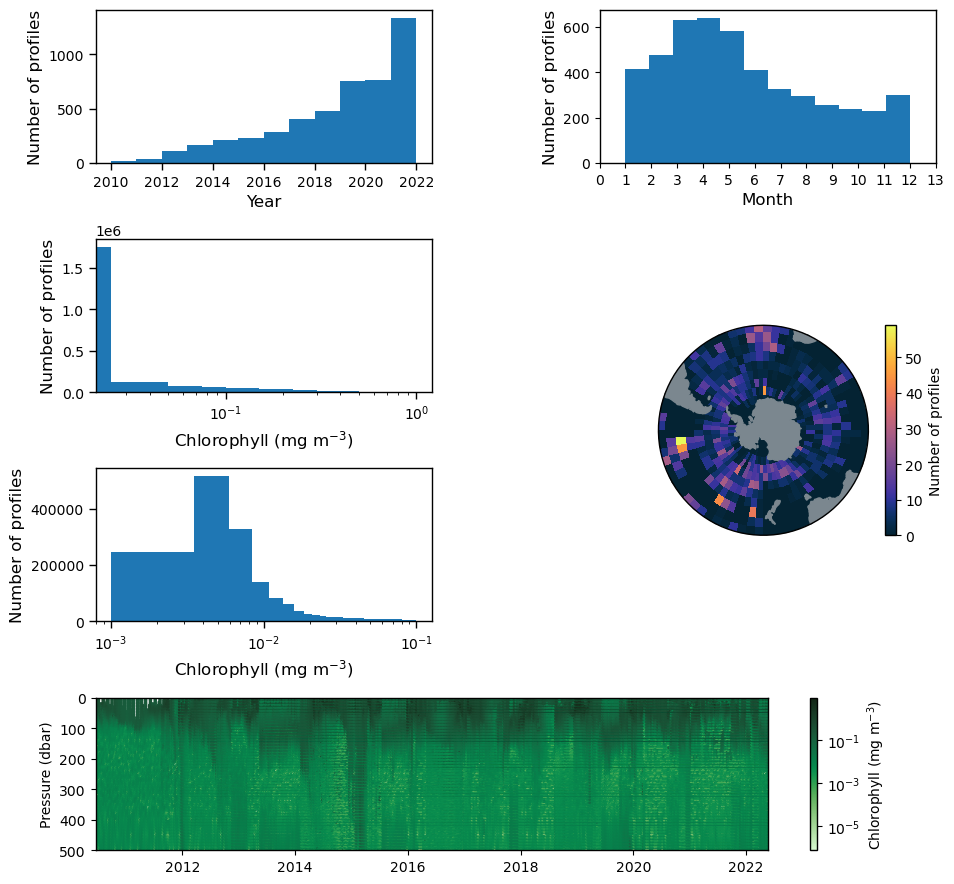

sigma_theta


<Figure size 640x480 with 0 Axes>

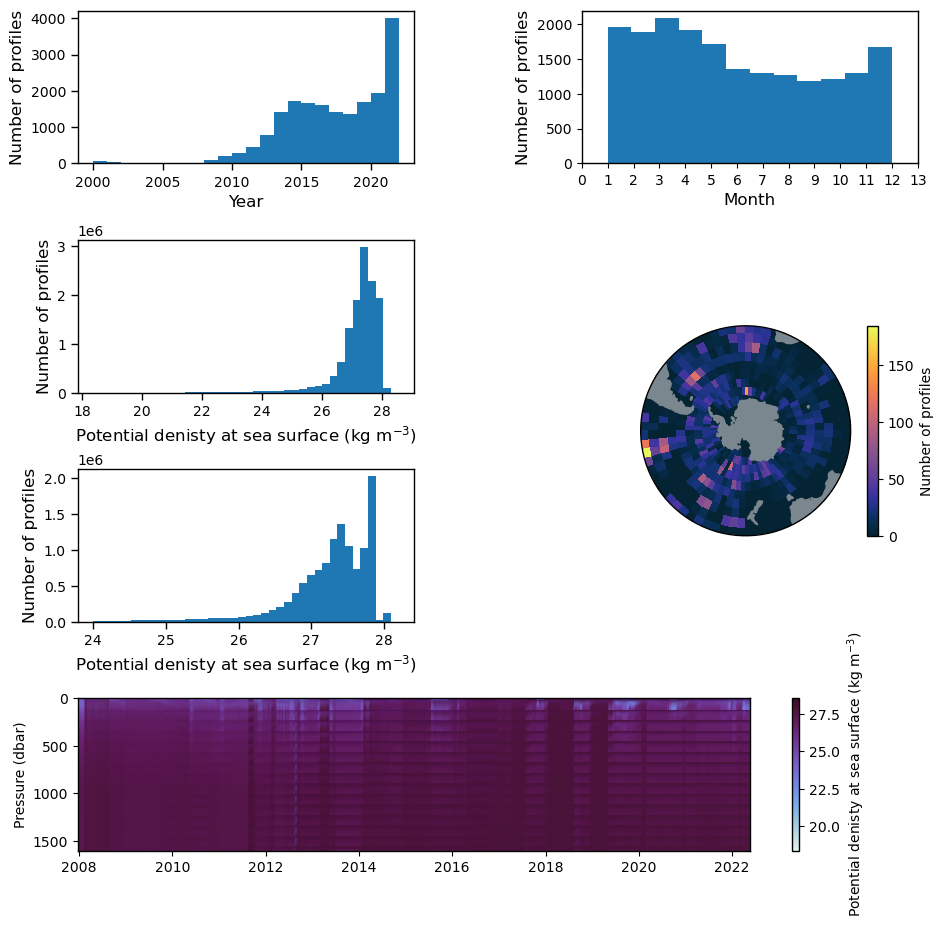

b_bp700


<Figure size 640x480 with 0 Axes>

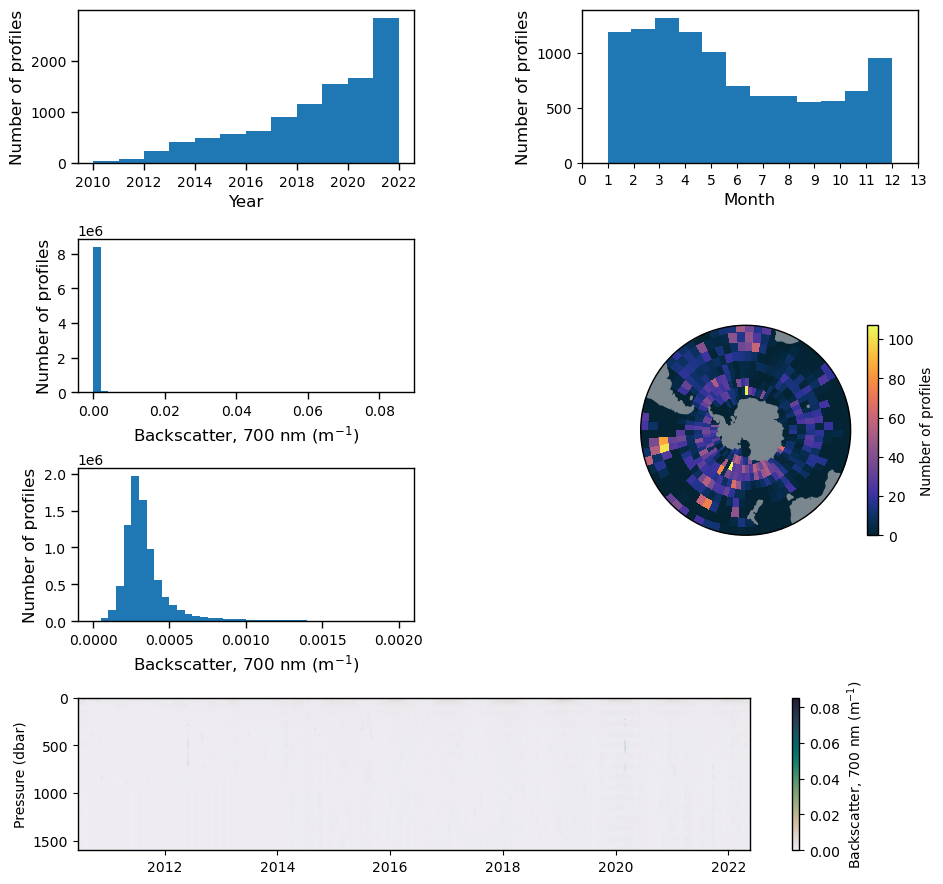

poc


<Figure size 640x480 with 0 Axes>

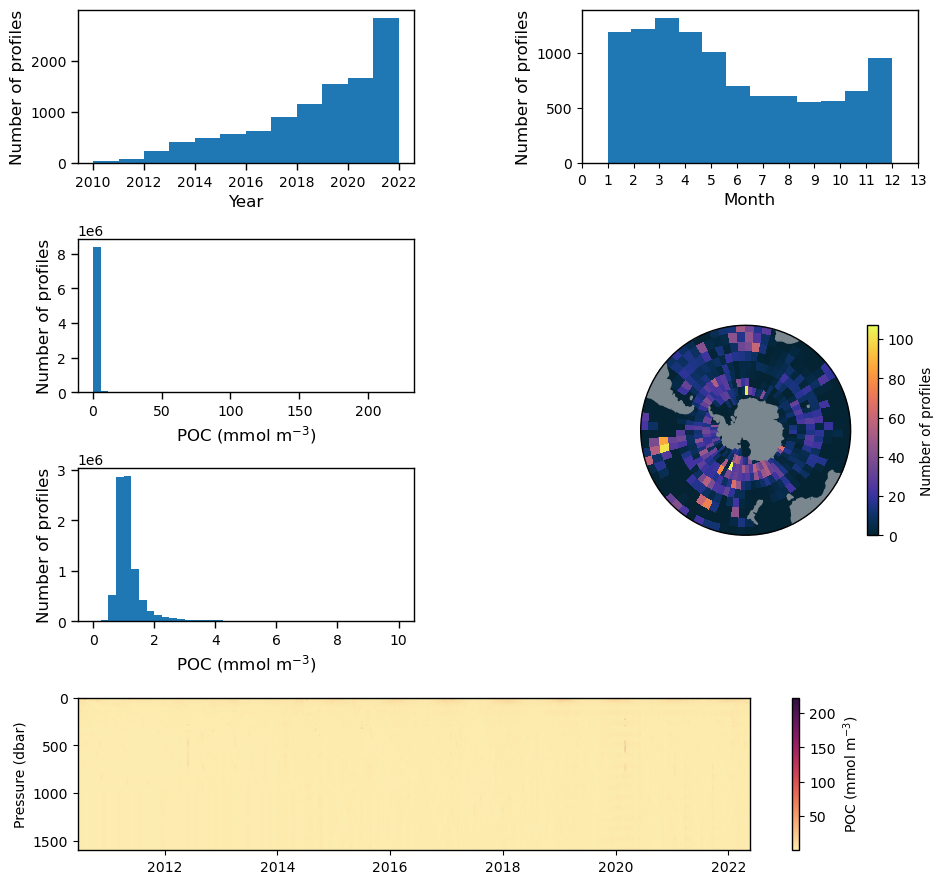

cdom


<Figure size 640x480 with 0 Axes>

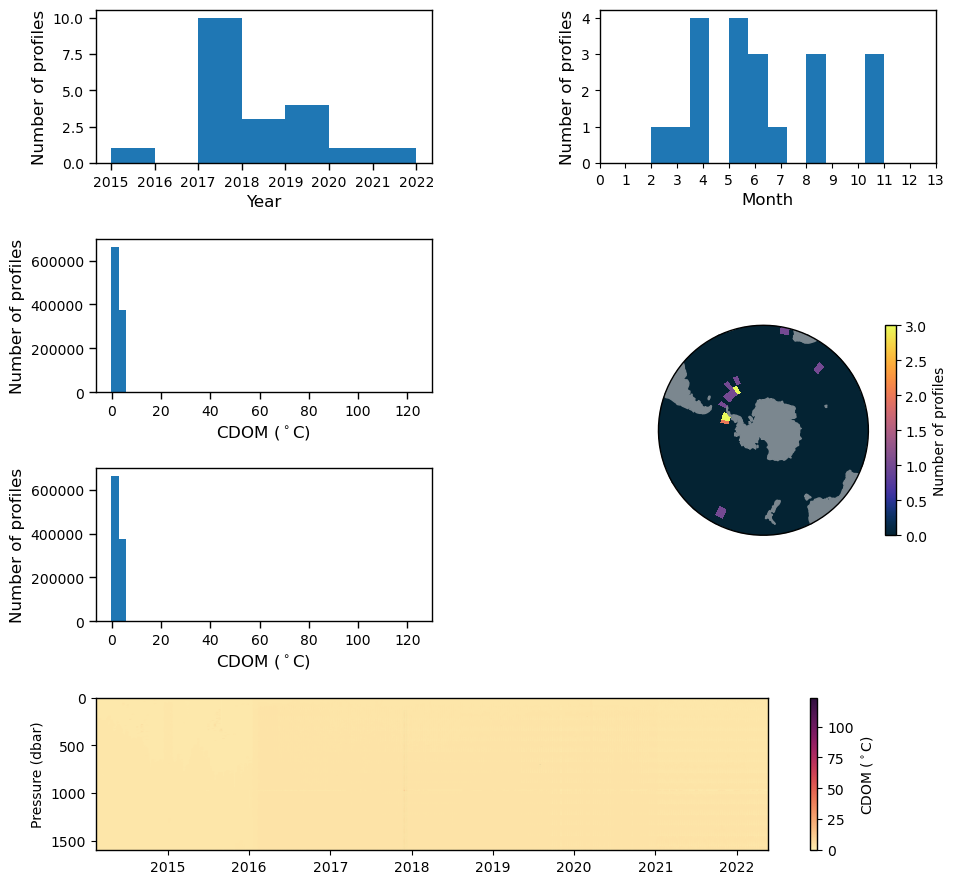

In [9]:
for variable in ['temperature', 'salinity', 'pco2', 'dic', 'talk', 'pH', 'oxygen', 'nitrate', 'chl', 'sigma_theta', 'b_bp700', 'poc', 'cdom']:
    print(variable)
    plot_data_visualization(datasets_all, variable)

In [ ]:
## TO DO
# figure out why boxes aren't aligned with month ticks
# (DONE) figure out how to add bottom section plot
# (DONE) figure out how to plot sections
# (DONE) do this plot for all variables
# (DONE) QC data based on plots
# (DONE) re-do plots
# get into GMM!